# Viking20x Labrador Sea budget


### Navigate with arrows, across and down (usually down to see the plots, across for next category). Presentation plan can be revealed with the Esc key.

- reads in section data produced on GEOMAR JupyterLab
- plots the section data
- calculates densities
- budget in density space

In [7]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import brokenline_new as bl   # in . folder. Holds some routines for transport calculation.
from matplotlib import colors as c
import matplotlib.dates as mdates
from matplotlib import ticker
import seaborn as sns
import cmocean as co 
from xhistogram.xarray import histogram
import seawater as sw
from scipy import signal

In [64]:
sns.set(style="whitegrid")

xr.set_options(keep_attrs=True)
np.warnings.filterwarnings('ignore')

sns.set_palette("colorblind")
xr.set_options(keep_attrs=True);

plt.rc('font', size=14) #controls default text size
plt.rc('axes', titlesize=14) #fontsize of the title
plt.rc('axes', labelsize=14) #fontsize of the x and y labels
plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
plt.rc('ytick', labelsize=14) #fontsize of the y tick labels
plt.rc('legend', fontsize=14) #fontsize of the legend
plt.rc('savefig', dpi=300)       # higher res outputs

In [9]:
def butter_lowpass(cutoff, fs, order=2):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    sos = signal.butter(order, normal_cutoff, btype='low', analog=False, output='sos')
    return sos

def butter_lowpass_filtfilt(data, cutoff, fs, order=5):
    sos = butter_lowpass(cutoff, fs, order=order)
    y = signal.sosfiltfilt(sos, data,padtype='even',padlen=50)
    return y

In [10]:
def lowpass_filter(timser):
    timser_mean = timser.mean()
    timser_filtered = xr.apply_ufunc(butter_lowpass_filtfilt, timser-timser_mean,cutoff,fs,
                     dask='parallelized')
    return timser_filtered + timser_mean


In [11]:
fs = 12.0  #samples per year
cutoff = 0.5


### Set up paths and read in data

In [12]:
# Project path
project_path = Path.cwd() 
project_path = project_path.resolve()

# Section data file
path_data_section = Path('data_output/') 
fname_osnap = f'osnapSection1990to2019.nc'
fname_davis = f'davisStraitSection1990to2019.nc'
fname_hudso = f'hudsonBaySection1990to2019.nc'


path_data_output = project_path / path_data_section / "watermassBudget" / "surfaceFluxes" 


# output figure path
path_figures = Path('results/figures/') 

# model mask file
global_data_path = Path("/data/iAtlantic/")
experiment_name = "VIKING20X.L46-KKG36107B"
mesh_mask_file = global_data_path / "mask" / experiment_name / "1_mesh_mask.nc"


In [13]:
mask = xr.open_dataset(mesh_mask_file)
fmask = mask['tmask'].isel(z=0)

section_osnap = xr.open_dataset(project_path / path_data_section / fname_osnap)
section_davis = xr.open_dataset(project_path / path_data_section / fname_davis)
section_hudso = xr.open_dataset(project_path / path_data_section / fname_hudso)

In [14]:
section_osnap

<xarray.Dataset>
Dimensions:       (c: 1280, z: 46, time_counter: 360)
Coordinates:
  * c             (c) float64 3.502e+03 7.005e+03 ... 4.225e+06 4.229e+06
  * z             (z) float64 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
  * time_counter  (time_counter) datetime64[ns] 1990-01-16T12:00:00 ... 2019-...
Data variables:
    u_normal      (time_counter, z, c) float64 ...
    u_along       (time_counter, z, c) float64 ...
    votemper      (time_counter, z, c) float64 ...
    vosaline      (time_counter, z, c) float64 ...
    ii            (c) int64 ...
    jj            (c) int64 ...
    dx            (c) float64 ...
    lat           (c) float32 ...
    lon           (c) float32 ...
    dz            (z, c) float64 ...
    mask          (z, c) float32 ...

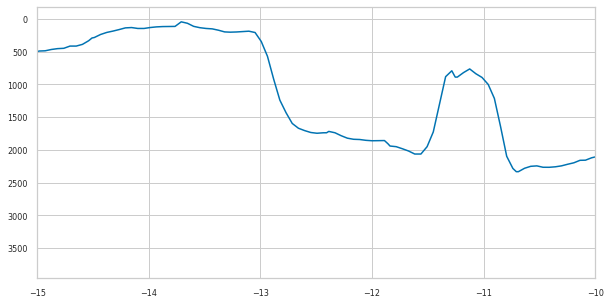

In [15]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(section_osnap.lon,(section_osnap.mask*section_osnap.dz).sum(dim='z'))
ax.set_xlim(-15,-10)
ax.invert_yaxis()


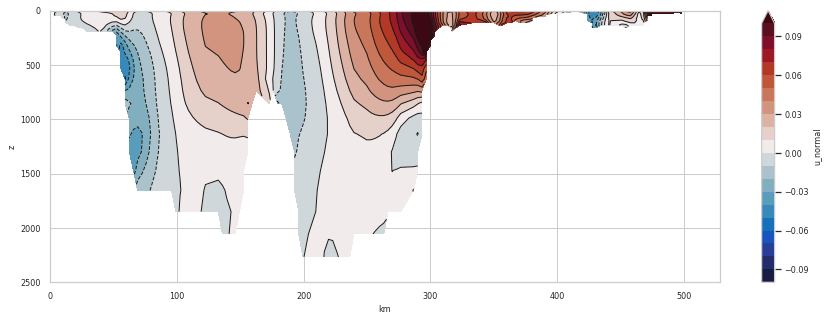

In [16]:
p = plt.figure(figsize=(15,5))    
section_right=section_osnap.where((section_osnap.c > 3700000) & (section_osnap.lon.diff(dim='c') > 0.04)).dropna(dim='c', how='all')
section_right['c']=(section_right.c/1000.0)-3700
section_right.u_normal.mean(dim='time_counter').plot.contourf(levels=np.arange(-0.1,0.11,0.01),cmap=co.cm.balance)
section_right.u_normal.mean(dim='time_counter').plot.contour(levels=np.arange(-0.1,0.11,0.01),colors='k',linewidths=1)
plt.ylim(2500,0)
plt.xlim(0,None)
plt.xlabel('km')

plt.savefig('viking20x_mean_u_normal_1990-2019.png',dpi=300)

In [17]:
section_right.lon

<xarray.DataArray 'lon' (c: 136)>
array([-13.764985 , -13.709395 , -13.6538105, -13.598228 , -13.54265  ,
       -13.487077 , -13.431507 , -13.37594  , -13.320378 , -13.214342 ,
       -13.1588125, -13.103287 , -13.047766 , -12.992248 , -12.936734 ,
       -12.881225 , -12.825719 , -12.770218 , -12.714721 , -12.659228 ,
       -12.60374  , -12.548256 , -12.492776 , -12.4373   , -12.331754 ,
       -12.276312 , -12.220874 , -12.165441 , -12.110011 , -12.054586 ,
       -11.9991665, -11.94375  , -11.888339 , -11.783113 , -11.7277355,
       -11.672363 , -11.616995 , -11.561631 , -11.506272 , -11.450918 ,
       -11.395569 , -11.340224 , -11.284884 , -11.180007 , -11.1247015,
       -11.069401 , -11.014105 , -10.958814 , -10.903527 , -10.848246 ,
       -10.79297  , -10.737699 , -10.6331415, -10.577905 , -10.522674 ,
       -10.467446 , -10.412226 , -10.357009 , -10.301798 , -10.246592 ,
       -10.191391 , -10.136195 , -10.031988 ,  -9.976828 ,  -9.921673 ,
        -9.866523 ,  -9.811378 ,  -9.756239 ,  -9.701104 ,  -9.645976 ,
        -9.590853 ,  -9.486969 ,  -9.431881 ,  -9.376799 ,  -9.321721 ,
        -9.26665  ,  -9.211584 ,  -9.156524 ,  -9.101469 ,  -9.04642  ,
        -8.991376 ,  -8.936338 ,  -8.881307 ,  -8.777834 ,  -8.722837 ,
        -8.667847 ,  -8.612863 ,  -8.557883 ,  -8.50291  ,  -8.447943 ,
        -8.392981 ,  -8.338025 ,  -8.283075 ,  -8.228131 ,  -8.173194 ,
        -8.118261 ,  -8.063335 ,  -8.008415 ,  -7.905446 ,  -7.850562 ,
        -7.7956843,  -7.740813 ,  -7.685947 ,  -7.631088 ,  -7.5762343,
        -7.521387 ,  -7.466546 ,  -7.411711 ,  -7.3568826,  -7.3020606,
        -7.2472444,  -7.192435 ,  -7.137631 ,  -7.082834 ,  -6.980399 ,
        -6.9256387,  -6.870885 ,  -6.8161373,  -6.761396 ,  -6.706661 ,
        -6.6519327,  -6.597211 ,  -6.5424957,  -6.487787 ,  -6.4330845,
        -6.378389 ,  -6.3236995,  -6.269017 ,  -6.214341 ,  -6.112411 ,
        -6.057772 ,  -6.00314  ,  -5.948515 ,  -5.893896 ,  -5.839284 ,
        -5.784679 ], dtype=float32)
Coordinates:
  * c        (c) float64 2.345 5.674 9.003 12.33 ... 518.5 521.8 525.2 528.5

In [18]:
transport_osnap_right = bl.calculate_transport(section_right,S_ref=34.92)


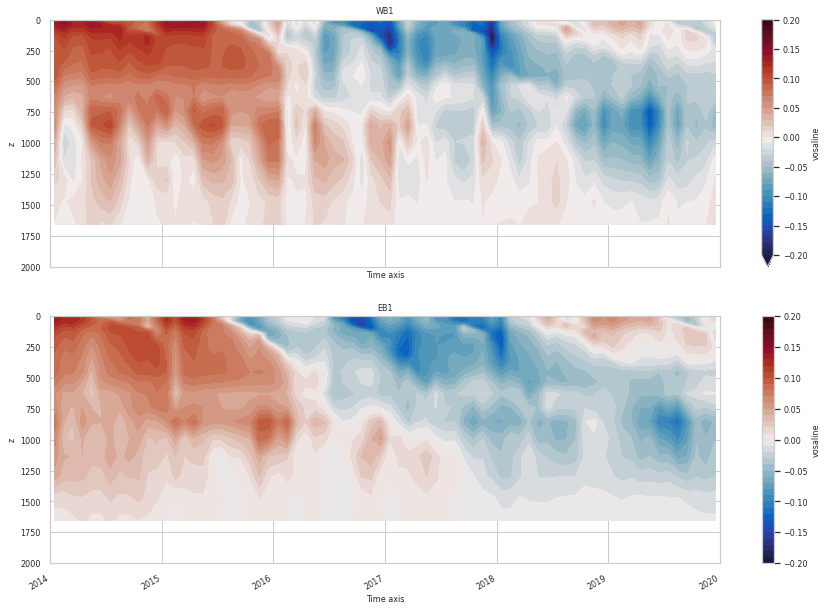

In [19]:
fig, ax = plt.subplots(2,figsize=(15,10),sharex=True)
(section_right.vosaline.isel(c=19,time_counter=slice(288,None,1))-section_right.vosaline.isel(c=19,time_counter=slice(288,None,1)).mean(dim=('time_counter'))).plot.contourf(ax=ax[0],x='time_counter',cmap=co.cm.balance,levels=np.arange(-0.2,0.21,0.01))
ax[0].set_xlim(np.datetime64('2014'),np.datetime64('2020'))
ax[0].set_ylim(2000,0)
ax[0].set_title('WB1')
(section_right.vosaline.isel(c=71,time_counter=slice(288,None,1))-section_right.vosaline.isel(c=71,time_counter=slice(288,None,1)).mean(dim=('time_counter'))).plot.contourf(ax=ax[1],x='time_counter',cmap=co.cm.balance,levels=np.arange(-0.2,0.21,0.01))
ax[1].set_xlim(np.datetime64('2014'),np.datetime64('2020'))
ax[1].set_ylim(2000,0)
ax[1].set_title('EB1')
plt.savefig('viking20x_salinity_anomaly_from_2014-2019_mean.png',dpi=300)


(16071.0, 18262.0)

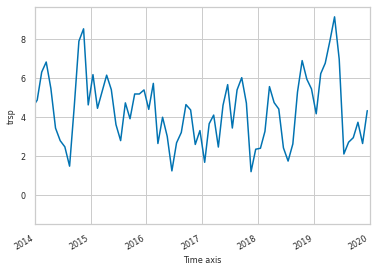

In [20]:
transport_osnap_right.trsp.plot()
plt.xlim(np.datetime64('2014'),np.datetime64('2020'))

In [21]:
# only want osnap w here
section_osnap = section_osnap.isel(c=slice(0,500,1))

# fix section ii,jj indices

section_osnap['ii'] = section_osnap.ii + 850
section_osnap['jj'] = section_osnap.jj + 1950
section_davis['ii'] = section_davis.ii + 650
section_davis['jj'] = section_davis.jj + 2400
section_hudso['ii'] = section_hudso.ii + 650
section_hudso['jj'] = section_hudso.jj + 1900



# add some missing attributes, mostly for automatic axis labels
# there is presumably a neater way to do this with a dictionary

section_osnap.vosaline.attrs['long_name']='salinity'
section_osnap.vosaline.attrs['units']='PSU'
section_osnap.votemper.attrs['long_name']='potential temperature'
section_osnap.votemper.attrs['units']='$\degree C$'
section_osnap.c.attrs['long_name']='Distance'
section_osnap.c.attrs['units']='m'
section_osnap.z.attrs['long_name']='Depth'
section_osnap.z.attrs['units']='m'
section_osnap.time_counter.attrs["long_name"] = 'Time'

section_davis.vosaline.attrs['long_name']='salinity'
section_davis.vosaline.attrs['units']='PSU'
section_davis.votemper.attrs['long_name']='potential temperature'
section_davis.votemper.attrs['units']='$\degree C$'
section_davis.c.attrs['long_name']='Distance'
section_davis.c.attrs['units']='m'
section_davis.z.attrs['long_name']='Depth'
section_davis.z.attrs['units']='m'
section_davis.time_counter.attrs["long_name"] = 'Time'

section_hudso.vosaline.attrs['long_name']='salinity'
section_hudso.vosaline.attrs['units']='PSU'
section_hudso.votemper.attrs['long_name']='potential temperature'
section_hudso.votemper.attrs['units']='$\degree C$'
section_hudso.c.attrs['long_name']='Distance'
section_hudso.c.attrs['units']='m'
section_hudso.z.attrs['long_name']='Depth'
section_hudso.z.attrs['units']='m'
section_hudso.time_counter.attrs["long_name"] = 'Time'

### plot the section on map

In [22]:
def plot_selected_points():
    p = plt.figure(figsize=(10,5))
    fmask.plot(cmap=c.ListedColormap(['gray','white']),add_colorbar=0)
    plt.plot(section_osnap.ii,section_osnap.jj, zorder=10)
    plt.plot(section_davis.ii,section_davis.jj, zorder=10)
    plt.plot(section_hudso.ii,section_hudso.jj, zorder=10)

    plt.ylabel("j")
    plt.xlabel("i")
    plt.title('Selected points')
    return


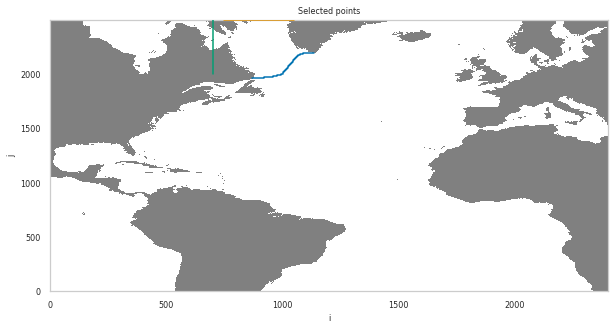

In [23]:
plot_selected_points()

### add sigma-0 to section datafile

In [24]:
# osnap
S = section_osnap.vosaline.data
T = section_osnap.votemper.data
sig0 = sw.pden(S,T,0.0,0.0)
sig0 -= 1000.0
section_osnap = section_osnap.assign({"vosigma0":(("time_counter", "z", "c"),sig0)})
#davis strait
S = section_davis.vosaline.data
T = section_davis.votemper.data
sig0 = sw.pden(S,T,0.0,0.0)
sig0 -= 1000.0
section_davis = section_davis.assign({"vosigma0":(("time_counter", "z", "c"),sig0)})
#hudson bay
S = section_hudso.vosaline.data
T = section_hudso.votemper.data
sig0 = sw.pden(S,T,0.0,0.0)
sig0 -= 1000.0
section_hudso = section_hudso.assign({"vosigma0":(("time_counter", "z", "c"),sig0)})


### plot an example vertical section

In [25]:
def plot_section(section):    
    fig,ax = plt.subplots(figsize=(15,5))
    # whole section
    section.isel(c=slice(None,None,1))['u_normal'].isel(time_counter=25).plot(cmap=co.cm.balance)
    section.isel(c=slice(None,None,1))['mask'].where(section['mask']==0).plot(cmap=c.ListedColormap(['gray']),add_colorbar=0)
    CS = section.isel(c=slice(None,None,1))['vosigma0'].isel(time_counter=25).plot.contour(cmap=co.cm.dense,vmin=27.5,vmax=27.8)
    ax.set_ylim(0,4000)
    fig.gca().invert_yaxis()
    ax.clabel(CS, inline=True, fontsize=8,fmt='%1.2f',inline_spacing=2)
    ax.set_ylabel("Depth (m)")
    ax.set_xlabel("Distance (m)")
    ax.set_title(np.datetime_as_string(section.time_counter[25].data,unit='D')+" Velocity normal to section. Positive into page.")
    return

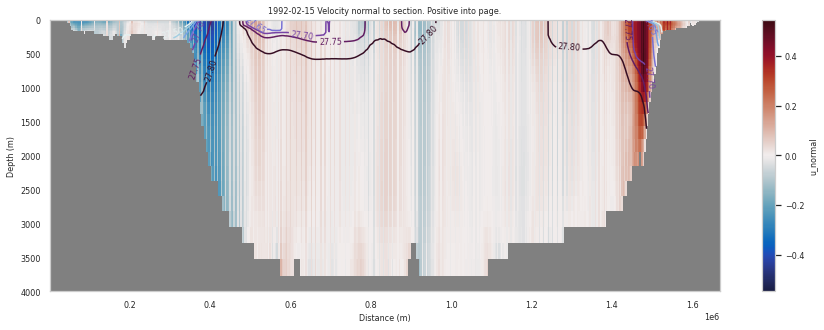

In [26]:
plot_section(section_osnap)
# plt.savefig(project_path / data_path / 'Viking20x_OSNAP_greenland_currents_2016-02-15.png')


### calculate transports into labrador sea

resulting arrays hold volume, heat and freshwater transports

reference salinity can be supplied S_ref (default 34.8).

In [27]:
transport_osnapw = bl.calculate_transport(section_osnap,S_ref=34.92)
transport_daviss = bl.calculate_transport(section_davis,S_ref=34.92)
transport_hudson = bl.calculate_transport(section_hudso,S_ref=34.92)

transport_osnapw.trsp.attrs["long_name"] = 'volume transport'
transport_osnapw.trsp.attrs["units"] = 'Sv'
transport_daviss.trsp.attrs["long_name"] = 'volume transport'
transport_daviss.trsp.attrs["units"] = 'Sv'
transport_hudson.trsp.attrs["long_name"] = 'volume transport'
transport_hudson.trsp.attrs["units"] = 'Sv'

transport_osnapw.ht_trsp.attrs["long_name"] = 'heat transport'
transport_osnapw.ht_trsp.attrs["units"] = 'W'
transport_daviss.ht_trsp.attrs["long_name"] = 'heat transport'
transport_daviss.ht_trsp.attrs["units"] = 'W'
transport_hudson.ht_trsp.attrs["long_name"] = 'heat transport'
transport_hudson.ht_trsp.attrs["units"] = 'W'

transport_osnapw.fw_trsp.attrs["long_name"] = 'freshwater transport'
transport_osnapw.fw_trsp.attrs["units"] = 'Sv'
transport_daviss.fw_trsp.attrs["long_name"] = 'freshwater transport'
transport_daviss.fw_trsp.attrs["units"] = 'Sv'
transport_hudson.fw_trsp.attrs["long_name"] = 'freshwater transport'
transport_hudson.fw_trsp.attrs["units"] = 'Sv'


### plot volume, heat and freshwater transport timeseries

There isn't a lot of overall trend in these transports. This is perhaps surprising when compared with the overturning streamfunction presented later

In [28]:
def plot_transport_timeseries():
    fig, ax = plt.subplots(figsize=(15,5))
    transport_osnapw.trsp.plot(marker='o',ms=2,linewidth=1,color='k',label = 'OSNAP_West Inwards')
    (-1*transport_daviss.trsp).plot(marker='o',ms=2,linewidth=1,label = 'Davis Strait Inwards')
    (-1*transport_hudson).trsp.plot(marker='o',ms=2,linewidth=1,label = 'Hudson Bay Inwards')
    (transport_osnapw.trsp-transport_daviss.trsp-transport_hudson.trsp).plot(marker='o',ms=2,linewidth=1,label = 'Net inwards')
    plt.legend();

    return

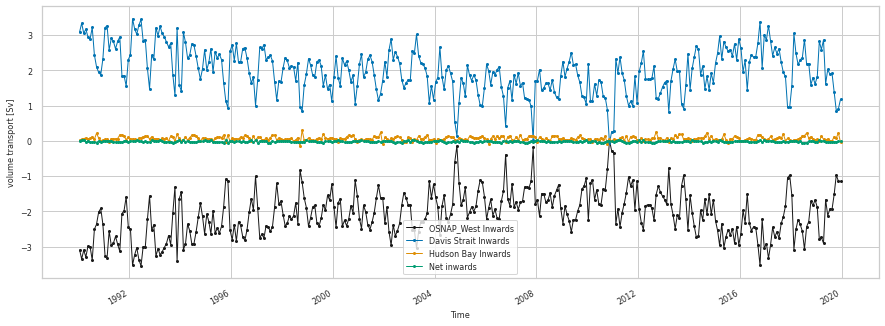

In [29]:
plot_transport_timeseries()

Mean net flow OSNAP East around zero, or small northward. Mean net flow OSNAP West is about 2Sv southward - this is generally surface water flow through from the north and freshwater inflow. Overall net flow about 2Sv southwards.

In [30]:
def plot_MHT_MFT(transport,transport_W,transport_E):
    fig, ax = plt.subplots(2,figsize=(15,10),sharex=True,gridspec_kw={'hspace': 0.02,'height_ratios': [1, 1]})

    (transport.ht_trsp
        .plot(ax=ax[0],marker='o',ms=2,linewidth=1,color='k',label='OSNAP West - Viking20x'))
    ((-1*transport_W.ht_trsp)
        .plot(ax=ax[0],marker='o',ms=2,linewidth=1,label='Davis Strait - Viking20x'))
    ((-1*transport_E.ht_trsp)
        .plot(ax=ax[0],marker='o',ms=2,linewidth=1,label='Hudson Bay - Viking20x'))
    ((transport.ht_trsp-transport_W.ht_trsp-transport_E.ht_trsp)
        .plot(ax=ax[0],marker='o',ms=2,linewidth=1,label='Net inwards - Viking20x'))

    
    (transport.fw_trsp
         .plot(ax=ax[1],marker='o',ms=2,linewidth=1,color='k',label='OSNAP West - Viking20x'))
    ((-1*transport_W.fw_trsp)
         .plot(ax=ax[1],marker='o',ms=2,linewidth=1,label='Davis Strait - Viking20x'))
    ((-1*transport_E.fw_trsp)
         .plot(ax=ax[1],marker='o',ms=2,linewidth=1,label='Hudson Bay - Viking20x'))
    ((transport.fw_trsp-transport_W.fw_trsp-transport_E.fw_trsp)
         .plot(ax=ax[1],marker='o',ms=2,linewidth=1,label='Net inwards - Viking20x'))
    ax[0].legend()
    ax[1].legend()
    ax[0].set_xlabel('')
    

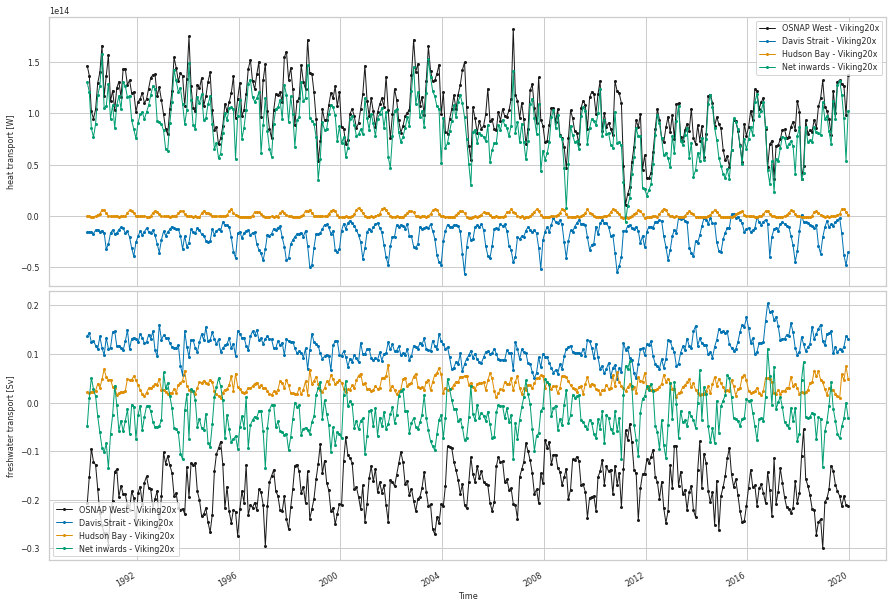

In [31]:
plot_MHT_MFT(transport_osnapw,transport_daviss,transport_hudson)
# plt.savefig(project_path / path_figures / 'Viking20x_OSNAP_MHT_MFT_2010-18.png')

In [32]:
def plot_MFT_refs(transport,transport_W,transport_E):
    fig, ax = plt.subplots(figsize=(15,5))

    salt_trsp = -(transport.fw_trsp - transport.trsp)*34.8
    salt_trsp_w = -(transport_W.fw_trsp - transport_W.trsp)*34.8
    salt_trsp_e = -(transport_E.fw_trsp - transport_E.trsp)*34.8

    fw_trsp36 = (transport.fw_trsp - transport.trsp)*34.8/35.0 + transport.trsp
    fw_trsp_w36 = (transport_W.fw_trsp - transport_W.trsp)*34.8/35.0 + transport_W.trsp
    fw_trsp_e36 = (transport_E.fw_trsp - transport_E.trsp)*34.8/35.0 + transport_E.trsp 
    
    (fw_trsp36
         .plot(ax=ax,marker='o',ms=2,linewidth=1,color='k'))
    ((-1*fw_trsp_w36)
         .plot(ax=ax,marker='o',ms=2,linewidth=1,color='C0'))
    ((-1*fw_trsp_e36)
         .plot(ax=ax,marker='o',ms=2,linewidth=1,color='C1'))
    ((fw_trsp36-fw_trsp_w36-fw_trsp_e36)
         .plot(ax=ax,marker='o',ms=2,linewidth=1,color='C2'))
    
    (fw_trsp36.rolling(time_counter=24, center=True).mean()
         .plot(ax=ax,linewidth=1,color='k',label='OSNAP West - Viking20x'))
    ((-1*fw_trsp_w36.rolling(time_counter=24, center=True).mean())
         .plot(ax=ax,linewidth=1,color='C0',label='Davis Strait - Viking20x'))
    ((-1*fw_trsp_e36.rolling(time_counter=24, center=True).mean())
         .plot(ax=ax,linewidth=1,color='C1',label='Hudson Bay - Viking20x'))
    ((fw_trsp36.rolling(time_counter=24, center=True).mean()-
      fw_trsp_w36.rolling(time_counter=24, center=True).mean() - 
      fw_trsp_e36.rolling(time_counter=24, center=True).mean())
         .plot(ax=ax,linewidth=1,color='C2',label='Net inwards - Viking20x'))
    
    ax.legend()
    ax.set_xlabel('')
    

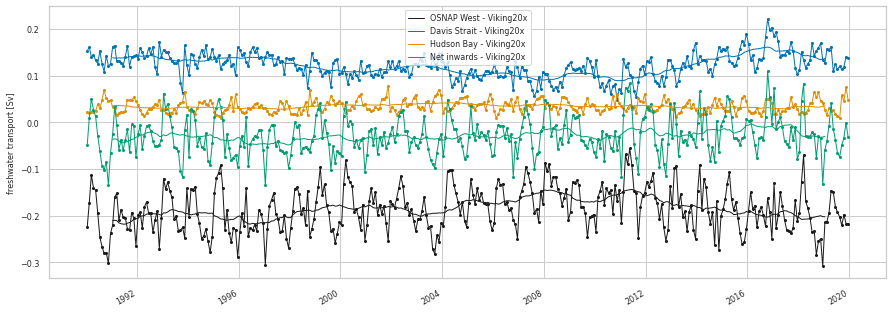

In [33]:
plot_MFT_refs(transport_osnapw,transport_daviss,transport_hudson)

## calculate overturning streamfunction

In [34]:
def calculate_amoc(section2):
    """ Calculate transports binned on sigma layers

    Parameters
    ----------
    section: xarray.Dataset
        Dataset returned by broken_line.section() with vosigma0 added
  
    Returns
    -------
    trsp : xarray.Dataset
        Dataset of shape (t,sigma)
        "t" - time
        "sigma" - density bins

    """
    # Volume transport
    trsp = section2['u_normal'] * section2['dx'] * section2['dz'] / 1e06
    
    sigbins = np.arange(10.0,28, 0.01)

    trsp_sigma = histogram(section2.vosigma0, bins=[sigbins], dim=["z","c"], weights=trsp)
    trsp_sigma.attrs["long_name"]='MOC'
    trsp_sigma.vosigma0_bin.attrs["long_name"]= r'$\sigma_{\theta}$'
    trsp_sigma.time_counter.attrs["long_name"]= "Date"
    trsp_sigma.vosigma0_bin.attrs["units"]= r'$\mathrm{kg\ m^{-3}}$'
    trsp_sigma.attrs["units"]='Sv'
    
    return trsp_sigma

In [35]:
def calc_amoc(section):
    amoc = calculate_amoc(section)
    return amoc

In [36]:
amoc_osnap = calc_amoc(section_osnap)
amoc_davis = calc_amoc(section_davis)
amoc_hudso = calc_amoc(section_hudso)


In [37]:
amoc_osnap

<xarray.DataArray 'histogram_vosigma0' (time_counter: 360, vosigma0_bin: 1799)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1990-01-16T12:00:00 ... 2019-...
  * vosigma0_bin  (vosigma0_bin) float64 10.0 10.02 10.02 ... 27.96 27.97 27.98
Attributes:
    long_name:  MOC
    units:      Sv

In [38]:
    # sum from low to high density

amoc_osnap_sumup=amoc_osnap.cumsum(dim="vosigma0_bin")
amoc_davis_sumup=amoc_davis.cumsum(dim="vosigma0_bin")
amoc_hudso_sumup=amoc_hudso.cumsum(dim="vosigma0_bin")

                    

### alternatively, calculate sum from bottom to top (downwards in density from from high to low)

In [39]:

amoc_osnap_sumdown=(amoc_osnap.cumsum(dim="vosigma0_bin",keep_attrs=True)
                    -amoc_osnap.sum(dim="vosigma0_bin",keep_attrs=True))
amoc_davis_sumdown=(amoc_davis.cumsum(dim="vosigma0_bin",keep_attrs=True)
                      -amoc_davis.sum(dim="vosigma0_bin",keep_attrs=True))
amoc_hudso_sumdown=(amoc_hudso.cumsum(dim="vosigma0_bin",keep_attrs=True)
                      -amoc_hudso.sum(dim="vosigma0_bin",keep_attrs=True))

### plot overturning streamfunction vs density class.

Accumulated from low to high density. MOC is the maximum of this streamfunction (blue dots monthly, orange dot overall mean).  
**May need to right-click and 'view image' to get the whole figure.**

In [40]:
def plot_amoc(osnap_sum,osnap_w_sum,osnap_e_sum):
    fig, ax = plt.subplots(2,4,figsize=(15,12),gridspec_kw={'hspace': 0.01, 'wspace': 0.1,'height_ratios': [1, 4]})
    plt.tight_layout()

# split plot vertically to emphasise the higher density levels

# lower density section
    
    (osnap_sum
        .plot.line(ax=ax[0,0],y="vosigma0_bin",add_legend=False,color='darkgrey',linewidth=0.4))
    (osnap_sum
         .mean(dim='time_counter')
         .plot.line(ax=ax[0,0],y="vosigma0_bin",add_legend=False,color='k',linewidth=1.4))

    (osnap_w_sum
        .plot.line(ax=ax[0,1],y="vosigma0_bin",add_legend=False,color='darkgrey',linewidth=0.4))
    (osnap_w_sum
        .mean(dim='time_counter')
        .plot.line(ax=ax[0,1],y="vosigma0_bin",add_legend=False,color='k',linewidth=1.4))

    (osnap_e_sum
        .plot.line(ax=ax[0,2],y="vosigma0_bin",add_legend=False,color='darkgrey',linewidth=0.4))
    (osnap_e_sum
        .mean(dim='time_counter')
        .plot.line(ax=ax[0,2],y="vosigma0_bin",add_legend=False,color='k',linewidth=1.4))

    ((osnap_sum-osnap_w_sum-osnap_e_sum)
        .plot.line(ax=ax[0,3],y="vosigma0_bin",add_legend=False,color='darkgrey',linewidth=0.4))
    ((osnap_sum-osnap_w_sum-osnap_e_sum)
        .mean(dim='time_counter')
        .plot.line(ax=ax[0,3],y="vosigma0_bin",add_legend=False,color='k',linewidth=1.4))

# higher density section
    (osnap_sum
         .plot.line(ax=ax[1,0],y="vosigma0_bin",add_legend=False,color='darkgrey',linewidth=0.4))
    (osnap_sum
         .mean(dim='time_counter')
         .plot.line(ax=ax[1,0],y="vosigma0_bin",add_legend=False,color='k',linewidth=1.4))
#     (osnap_sum
#          .isel(vosigma0_bin=osnap_sum.argmax(dim="vosigma0_bin"))
#          .plot(ax=ax[1,0],y="vosigma0_bin",marker='o',ms=2,linewidth=0))
    
    (osnap_w_sum
         .plot.line(ax=ax[1,1],y="vosigma0_bin",add_legend=False,color='darkgrey',linewidth=0.4))
    (osnap_w_sum
         .mean(dim='time_counter')
         .plot.line(ax=ax[1,1],y="vosigma0_bin",add_legend=False,color='k',linewidth=1.4))
#     (osnap_w_sum
#          .isel(vosigma0_bin=osnap_w_sum.argmax(dim="vosigma0_bin"))
#          .plot(ax=ax[1,1],y="vosigma0_bin",marker='o',ms=2,linewidth=0))
    
    (osnap_e_sum
         .plot.line(ax=ax[1,2],y="vosigma0_bin",add_legend=False,color='darkgrey',linewidth=0.4))
    (osnap_e_sum
         .mean(dim='time_counter')
         .plot.line(ax=ax[1,2],y="vosigma0_bin",add_legend=False,color='k',linewidth=1.4))
#     (osnap_e_sum
#          .isel(vosigma0_bin=osnap_e_sum.argmax(dim="vosigma0_bin"))
#          .plot(ax=ax[1,2],y="vosigma0_bin",marker='o',ms=2,linewidth=0))
    ((osnap_sum-osnap_w_sum-osnap_e_sum)
        .plot.line(ax=ax[1,3],y="vosigma0_bin",add_legend=False,color='darkgrey',linewidth=0.4))
    ((osnap_sum-osnap_w_sum-osnap_e_sum)
        .mean(dim='time_counter')
        .plot.line(ax=ax[1,3],y="vosigma0_bin",add_legend=False,color='k',linewidth=1.4))



# # add maxima to mean curve
#     def amoc_max(amoc):
#         return (amoc.mean(dim='time_counter')
#             .isel(vosigma0_bin=amoc.mean(dim='time_counter').argmax(dim="vosigma0_bin")))
    
#     osnap_max = amoc_max(osnap_sum)
#     osnap_w_max = amoc_max(osnap_w_sum)
#     osnap_e_max = amoc_max(osnap_e_sum)

#     ax[1,0].scatter(osnap_max.data,osnap_max.vosigma0_bin.data,color='C1',zorder=10)
#     ax[1,1].scatter(osnap_w_max.data,osnap_w_max.vosigma0_bin.data,color='C1',zorder=10)
#     ax[1,2].scatter(osnap_e_max.data,osnap_e_max.vosigma0_bin.data,color='C1',zorder=10)

# set up axes
    ax[0,0].set_ylim([26.99,24.5])
    ax[0,1].set_ylim([26.99,24.5])
    ax[0,2].set_ylim([26.99,24.5])
    ax[0,3].set_ylim([26.99,24.5])
    ax[0,0].set_xlim([-5,18])
    ax[0,1].set_xlim([-5,2])
    ax[0,2].set_xlim([-2,2])
    ax[0,3].set_xlim([-4,19])
    ax[0,0].set_title('OSNAP West')
    ax[0,1].set_title('Davis Strait')
    ax[0,2].set_title('Hudson Bay')
    ax[0,3].set_title('Net')

    ax[1,0].set_ylim([28,27])
    ax[1,1].set_ylim([28,27])
    ax[1,2].set_ylim([28,27])
    ax[1,3].set_ylim([28,27])
    ax[1,0].set_xlim([-5,18])
    ax[1,1].set_xlim([-5,2])
    ax[1,2].set_xlim([-2,2])
    ax[1,3].set_xlim([-4,19])
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for axis in ax.flat:
        axis.label_outer()

    # plt.savefig('Viking20x_OSNAP_overturning_streamfunction_2014-18.png')
    return

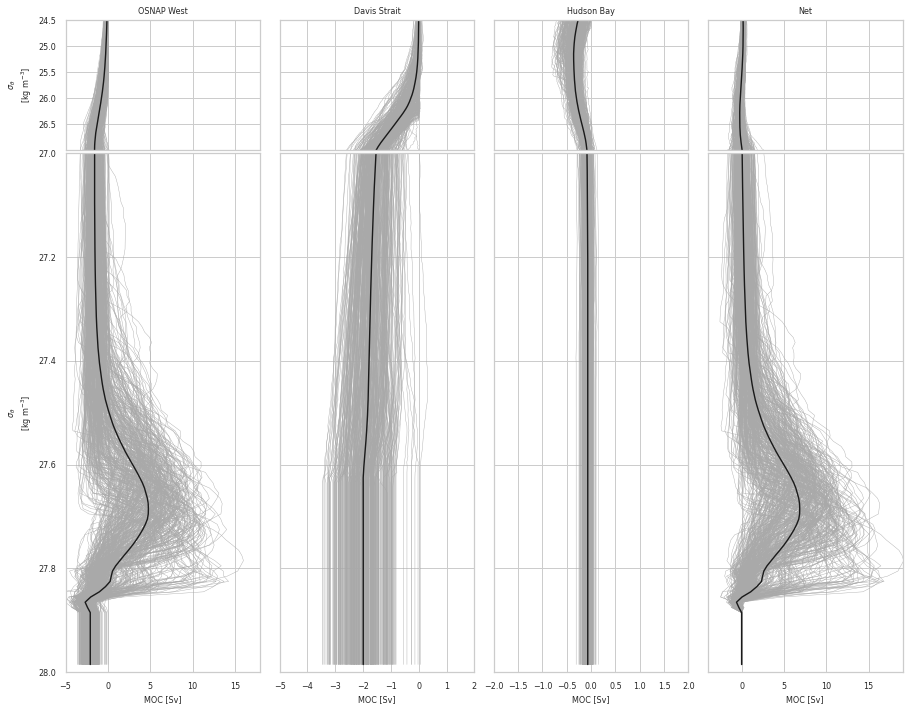

In [41]:
plot_amoc(amoc_osnap_sumup,amoc_davis_sumup,amoc_hudso_sumup)

(26.0, 27.984999999999616)

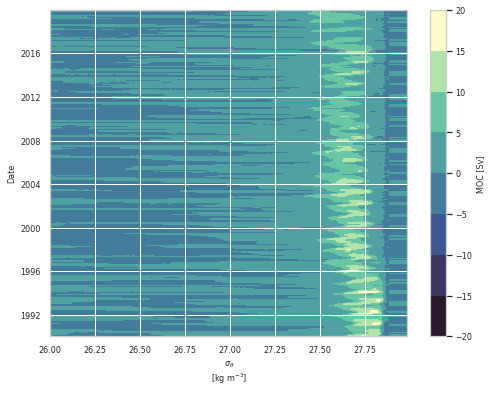

In [42]:
fig,ax = plt.subplots(figsize=(8,6))
ax.grid(True,color='w',zorder=10,linewidth=1)
(amoc_osnap_sumup-amoc_davis_sumup-amoc_hudso_sumup).plot.contourf(ax=ax,cmap=co.cm.deep_r,levels=10,zorder=0)
ax.set_xlim(left=26)
# amoc_osnap_e_sumup.cumsum(dim='vosigma0_bin').plot.contourf(ax=ax,cmap=co.cm.deep_r,levels=50,zorder=0)


## plot overturning timeseries

In [43]:
def plot_amoc_timeseries(amoc_osnap_sum,amoc_osnap_w_sum,amoc_osnap_e_sum):
    fig, ax = plt.subplots(figsize=(15,5))
    ((amoc_osnap_sum-amoc_davis_sumup-amoc_hudso_sumup).isel(vosigma0_bin=amoc_osnap_sum.argmax(dim="vosigma0_bin"))
        .plot(ax=ax,x="time_counter",marker='o',ms=2,linewidth=1,color='k',label='Net'))

    ax.legend();
    # plt.savefig('Viking20x_OSNAP_MOC_timeseries.png')
    return


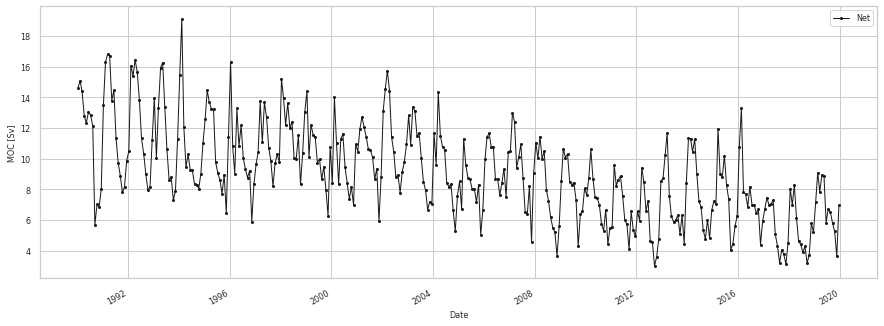

In [44]:
plot_amoc_timeseries(amoc_osnap_sumup,amoc_davis_sumup,amoc_hudso_sumup)
# plt.savefig(project_path / path_figures / 'Viking20x_OSNAP_MOC_2010-18.png')

Notice the downward trend. Weakening overturning in both OSNAP West and East.

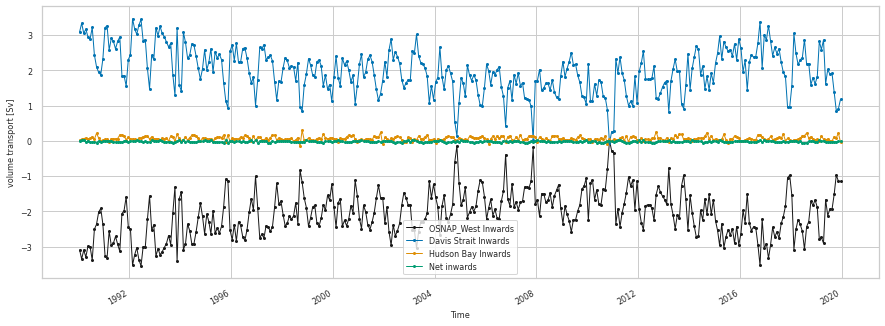

In [45]:
plot_transport_timeseries()

## Plot the transports accumulated from west to east

This corresponds to a plot in Lozier et al. 2019 Science paper. Viking20x salinity structure has some differences from the observed, particularly in the Iceland Basin. Viking20x densities are generally a bit light.

In [179]:
section_osnap

<xarray.Dataset>
Dimensions:       (c: 500, z: 46, time_counter: 360)
Coordinates:
  * c             (c) float64 3.502e+03 7.005e+03 ... 1.664e+06 1.667e+06
  * z             (z) float64 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
  * time_counter  (time_counter) datetime64[ns] 1990-01-16T12:00:00 ... 2019-...
Data variables:
    u_normal      (time_counter, z, c) float64 ...
    u_along       (time_counter, z, c) float64 ...
    votemper      (time_counter, z, c) float64 nan nan nan nan ... nan nan nan
    vosaline      (time_counter, z, c) float64 nan nan nan nan ... nan nan nan
    ii            (c) int64 870 871 872 873 874 874 ... 1131 1132 1133 1134 1135
    jj            (c) int64 1959 1959 1959 1959 1959 ... 2193 2193 2193 2193
    dx            (c) float64 3.502e+03 3.502e+03 ... 3.118e+03 3.118e+03
    lat           (c) float32 52.08 52.08 52.08 52.09 ... 59.97 59.97 59.98
    lon           (c) float32 -56.13 -56.08 -56.03 ... -43.82 -43.77 -43.71
    dz            (z, c) float64 6.191 6.191 6.191 6.191 ... 250.4 250.4 250.4
    mask          (z, c) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    vosigma0      (time_counter, z, c) float64 nan nan nan nan ... nan nan nan

In [207]:
def plot_westtoeast_accumulated_transports(section):

    section_upper = section.where(section.vosigma0 < 27.68)
    section_upper = section.isel(z=slice(0,22))
    section_lower = section.where(section.vosigma0 >= 27.6)
    trsp = section['u_normal'] * section['dx'] * section['dz'] / 1e06
    trsp_lower = section_lower['u_normal'] * section['dx'] * section['dz'] / 1e06
    trsp_upper = section_upper['u_normal'] * section['dx'] * section['dz'] / 1e06

    trsp.attrs['long_name']='Transport'
    trsp.attrs['units']='Sv'
    trsp_lower.attrs['long_name']='Transport'
    trsp_lower.attrs['units']='Sv'
    trsp_upper.attrs['long_name']='Transport'
    trsp_upper.attrs['units']='Sv'
    sns.set_palette("colorblind")

    fig, ax = plt.subplots(2,figsize=(15,13),sharex=True,gridspec_kw={'hspace': 0.01,'height_ratios': [1, 1.5]})
    plt.tight_layout()
    
#     (trsp.sum(dim='z',keep_attrs=True).cumsum(dim='c').mean(dim=['time_counter'])
#         .plot(ax=ax[0],color='k',label='Full depth'))
#     (trsp_lower.sum(dim='z',keep_attrs=True).cumsum(dim='c').mean(dim=['time_counter'])
#         .plot(ax=ax[0],label='Lower limb'))
#     (((trsp_upper.isel(time_counter=slice( 0,36)).sum(dim='z',keep_attrs=True).cumsum(dim='c').mean(dim=['time_counter']))-
#     (trsp_upper.isel(time_counter=slice( 0,36)).sum(dim='z',keep_attrs=True).cumsum(dim='c').mean(dim=['time_counter']))[-1])
#         .plot(ax=ax[0],label='Upper limb,2000-02',color='C0'))
#     (((trsp_upper.isel(time_counter=slice(36,72)).sum(dim='z',keep_attrs=True).cumsum(dim='c').mean(dim=['time_counter']))-
#     (trsp_upper.isel(time_counter=slice(36,72)).sum(dim='z',keep_attrs=True).cumsum(dim='c').mean(dim=['time_counter']))[-1])
#         .plot(ax=ax[0],label='Upper limb,2003-05',color='C1'))
#     (((trsp_upper.isel(time_counter=slice(72,108)).sum(dim='z',keep_attrs=True).cumsum(dim='c').mean(dim=['time_counter']))-
#     (trsp_upper.isel(time_counter=slice(72,108)).sum(dim='z',keep_attrs=True).cumsum(dim='c').mean(dim=['time_counter']))[-1])
#         .plot(ax=ax[0],label='Upper limb,2006-08',color='C2'))
#     (((trsp_upper.isel(time_counter=slice(108,144)).sum(dim='z',keep_attrs=True).cumsum(dim='c').mean(dim=['time_counter']))-
#     (trsp_upper.isel(time_counter=slice(108,144)).sum(dim='z',keep_attrs=True).cumsum(dim='c').mean(dim=['time_counter']))[-1])
#         .plot(ax=ax[0],label='Upper limb,2009-11',color='C3'))
#     (((trsp_upper.isel(time_counter=slice(144,180)).sum(dim='z',keep_attrs=True).cumsum(dim='c').mean(dim=['time_counter']))-
#     (trsp_upper.isel(time_counter=slice(144,180)).sum(dim='z',keep_attrs=True).cumsum(dim='c').mean(dim=['time_counter']))[-1])
#         .plot(ax=ax[0],label='Upper limb,2012-14',color='C4'))
#     (((trsp_upper.isel(time_counter=slice(180,216)).sum(dim='z',keep_attrs=True).cumsum(dim='c').mean(dim=['time_counter']))-
#     (trsp_upper.isel(time_counter=slice(180,216)).sum(dim='z',keep_attrs=True).cumsum(dim='c').mean(dim=['time_counter']))[-1])
#         .plot(ax=ax[0],label='Upper limb,2015-17',color='C5'))
#     (((trsp_upper.isel(time_counter=slice(216,228)).sum(dim='z',keep_attrs=True).cumsum(dim='c').mean(dim=['time_counter']))-
#     (trsp_upper.isel(time_counter=slice(216,228)).sum(dim='z',keep_attrs=True).cumsum(dim='c').mean(dim=['time_counter']))[-1])
#         .plot(ax=ax[0],label='Upper limb,2018-18',color='C6'))
    (trsp_upper.isel(time_counter=slice(0,60)).sum(dim='z',keep_attrs=True).cumsum(dim='c').mean(dim=['time_counter'])
        .plot(ax=ax[0],label=r'$\sigma_0 < 27.68$ 1990-94',color='C0'))
    (trsp_upper.isel(time_counter=slice(60,120)).sum(dim='z',keep_attrs=True).cumsum(dim='c').mean(dim=['time_counter'])
        .plot(ax=ax[0],label=r'$\sigma_0 < 27.68$ 1995-99',color='C1'))
    (trsp_upper.isel(time_counter=slice(120,180)).sum(dim='z',keep_attrs=True).cumsum(dim='c').mean(dim=['time_counter'])
        .plot(ax=ax[0],label=r'$\sigma_0 < 27.68$ 2000-04',color='C2'))
    (trsp_upper.isel(time_counter=slice(180,240)).sum(dim='z',keep_attrs=True).cumsum(dim='c').mean(dim=['time_counter'])
        .plot(ax=ax[0],label=r'$\sigma_0 < 27.68$ 2005-09',color='C3'))
    (trsp_upper.isel(time_counter=slice(240,300)).sum(dim='z',keep_attrs=True).cumsum(dim='c').mean(dim=['time_counter'])
        .plot(ax=ax[0],label=r'$\sigma_0 < 27.68$ 2010-14',color='C4'))
    (trsp_upper.isel(time_counter=slice(300,360)).sum(dim='z',keep_attrs=True).cumsum(dim='c').mean(dim=['time_counter'])
        .plot(ax=ax[0],label=r'$\sigma_0 < 27.68$ 2015-19',color='C5'))
    ax[0].legend()

    # whole section
    salinity_levels = [32,33,34,34.84,34.86,34.88,34.90,34.92,34.94,34.96,34.98,
                       35.0,35.05,35.1,35.15,35.2,35.25,35.3,35.35,35.4,35.45,35.5]
    density_levels = [25,26,27,27.3,27.5,27.6,27.7,27.75,27.8,27.85,27.88]
#     im = (section['vosaline'].mean(dim="time_counter")
#           .plot.contourf(ax=ax[1],cmap=co.cm.haline,levels=salinity_levels,
#                          cbar_kwargs={'orientation':'horizontal'}))
    im = (section.isel(time_counter=slice(12,24)).u_normal.mean(dim="time_counter")
          .plot.contourf(ax=ax[1],cmap=co.cm.balance,levels=np.arange(-0.5,0.51,0.05),
                         cbar_kwargs={'orientation':'horizontal'}))
    CS = (section.isel(time_counter=slice(12,24)).vosigma0.mean(dim="time_counter")
          .plot.contour(ax=ax[1],cmap=co.cm.dense,levels=density_levels,add_colorbar=0))
    section['mask'].where(section['mask']==0).plot(ax=ax[1],cmap=c.ListedColormap(['gray']),add_colorbar=0)

# plot formatting
    ax[1].set_ylim(0,4000)
    ax[1].invert_yaxis()
    ax[0].ticklabel_format(axis='x', style='sci', scilimits=(-3,3))

    ax[0].set_xlabel('')

    ax[1].clabel(CS, inline=True, fontsize=8,fmt='%1.2f',inline_spacing=2)
#     ax[0].set_xlim(0,650000)
#     ax[1].set_xlim(0,650000)
    plt.tight_layout()
#     plt.savefig('section_500_zoom.png', bbox_inches='tight',dpi=300)
#     plt.savefig('section_500_zoom.pdf', bbox_inches='tight',dpi=300)
    return



In [208]:
def plot_westtoeast_properties(section):
    
    section_left=section.where(section.c < 490000)

    section_upper = section_left.where(section_left.vosigma0 < 27.68)
#     section_upper = section.isel(z=slice(0,24))
    section_lower = section_left.where(section_left.vosigma0 >= 27.6)
    trsp = section_left['u_normal'] * section_left['dx'] * section_left['dz'] / 1e06
    trsp_lower = section_lower['u_normal'] * section_left['dx'] * section_left['dz'] / 1e06
    trsp_upper = section_upper['u_normal'] * section_left['dx'] * section_left['dz'] / 1e06

    trsp.attrs['long_name']='Transport'
    trsp.attrs['units']='Sv'
    trsp_lower.attrs['long_name']='Transport'
    trsp_lower.attrs['units']='Sv'
    trsp_upper.attrs['long_name']='Transport'
    trsp_upper.attrs['units']='Sv'

    fig, ax = plt.subplots(figsize=(9,4.5))
    plt.tight_layout()
    

    # whole section
#     salinity_levels = [32,33,34,34.2,34.5,34.6,34.7,34.8,34.9,34.92,34.94,34.96,34.98,
#                        35.0]
#     density_levels = [25,26,27,27.3,27.427.5,27.6,27.7,27.75,27.8,27.85,27.88]
    salinity_levels = [34,34.2,34.5,34.6]
    density_levels = [20,27,27.3,27.5,27.6]
    im2 = ((-1*((section_left.isel(time_counter=slice(240,360)).u_normal.mean(dim="time_counter"))
            -(section_left.isel(time_counter=slice(0,360)).u_normal.mean(dim="time_counter"))))
          .plot.contourf(ax=ax,cmap=co.cm.balance,levels=np.arange(-0.1,0.11,0.01),
                         cbar_kwargs={'orientation':'horizontal',
                                      'aspect':30,
                                      'pad':0.2,
                                      'label':'normal velocity difference [m s$^{-1}$]'}))
    CS1 = (section_left.isel(time_counter=slice(240,360)).vosigma0.mean(dim="time_counter")
          .plot.contour(ax=ax,cmap=co.cm.dense,levels=density_levels,add_colorbar=0))
    CS2 = (section_left.isel(time_counter=slice(0,360)).vosigma0.mean(dim="time_counter")
          .plot.contour(ax=ax,cmap=co.cm.dense,levels=density_levels,add_colorbar=0,linestyles='dashed'))
#     CS1 = (section.isel(time_counter=slice(168,180)).votemper.mean(dim="time_counter")
#           .plot.contour(ax=ax,cmap=co.cm.thermal,levels=np.arange(0,7,0.5),add_colorbar=0))
#     CS1 = (section.isel(time_counter=slice(168,180)).vosaline.mean(dim="time_counter")
#           .plot.contour(ax=ax,cmap=co.cm.haline,levels=salinity_levels,add_colorbar=0))
    section_left['mask'].where(section_left['mask']==0).plot(ax=ax,cmap=c.ListedColormap(['gray']),add_colorbar=0)

# plot formatting
    ax.set_ylim(0,750)
    ax.invert_yaxis()
    ax.ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
    ax.clabel(CS1, fontsize=12,fmt='%1.1f',inline_spacing=0,use_clabeltext=True)
#     ax.clabel(CS2, inline=True, fontsize=8,fmt='%1.1f',inline_spacing=-5)
    ax.set_xlim(0,490000)
    
    plt.savefig('.png',dpi=300)
    return



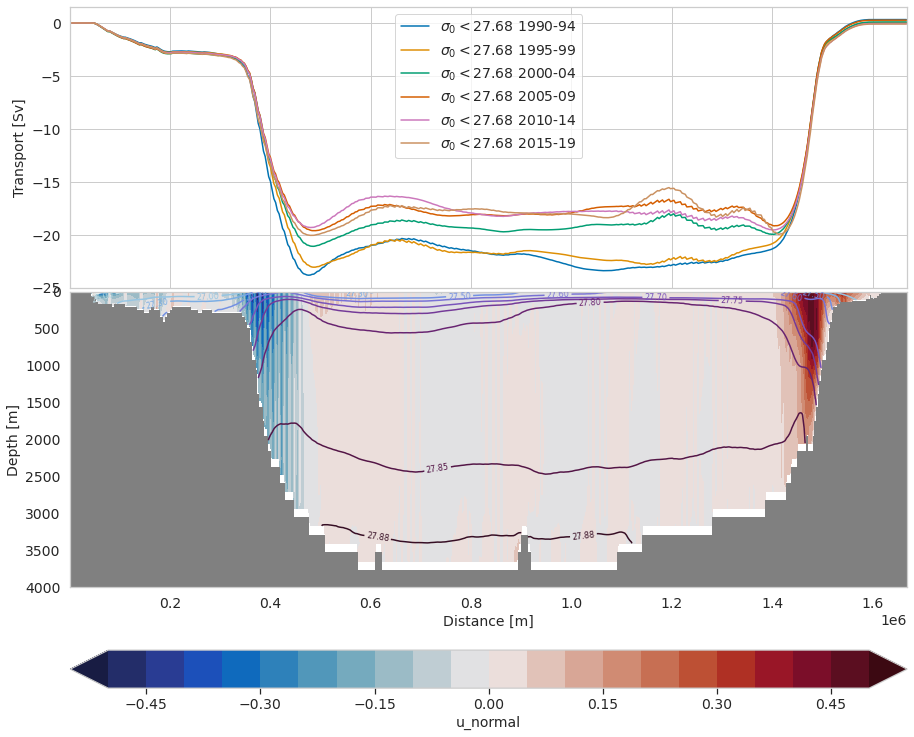

In [209]:
plot_westtoeast_accumulated_transports(section_osnap)

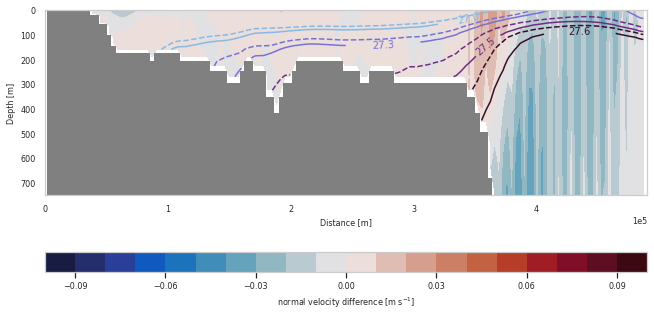

In [49]:
plot_westtoeast_properties(section_osnap)

## Compare low-to-high and high-to-low density summing of AMOC

I have no real idea which is 'correct'. If there is no net flow though the section then they are equivalent. But as there is some net flow through all our sections they are not.

This is perhaps, on the surface, more of a problem in the model than the data. This is because the data is adjusted for no net flow across the full section.

#### Plot MOC summed from high to low density

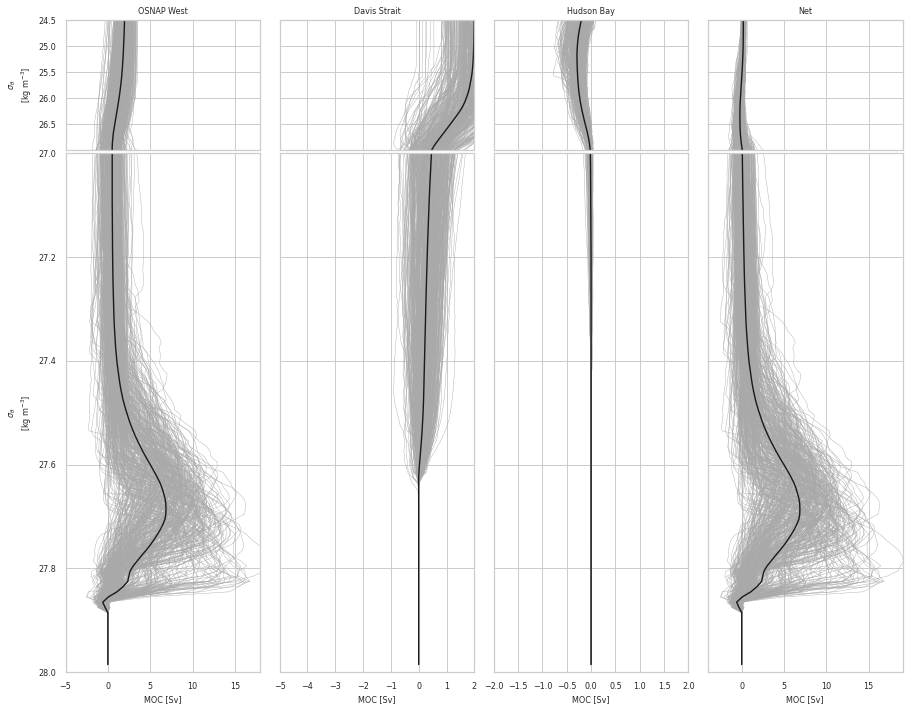

In [50]:
plot_amoc(amoc_osnap_sumdown,amoc_davis_sumdown,amoc_hudso_sumdown)

In [51]:
def plot_amoc_upvsdown_timeseries(amoc_sumup,amoc_sumdown):
    fig, ax = plt.subplots(figsize=(15,5))

# plot top-to-bottom sum
    (amoc_sumup.isel(vosigma0_bin=amoc_osnap_sumup.argmax(dim="vosigma0_bin"))
         .plot(ax=ax,x="time_counter",marker='o',ms=2,linewidth=1,color='k',
               label='Full array - Viking20x - top-to-bottom'))
# plot bottom-to-top sum
    (amoc_sumdown.isel(vosigma0_bin=amoc_osnap_sumdown.argmax(dim="vosigma0_bin"))
         .plot(ax=ax,x="time_counter",marker='o',ms=2,linewidth=1,color='k',linestyle='--',
               label='Full array - Viking20x - bottom-to-top'))

    ax.legend()
    ax.set_ylim([0,29.9])

    return


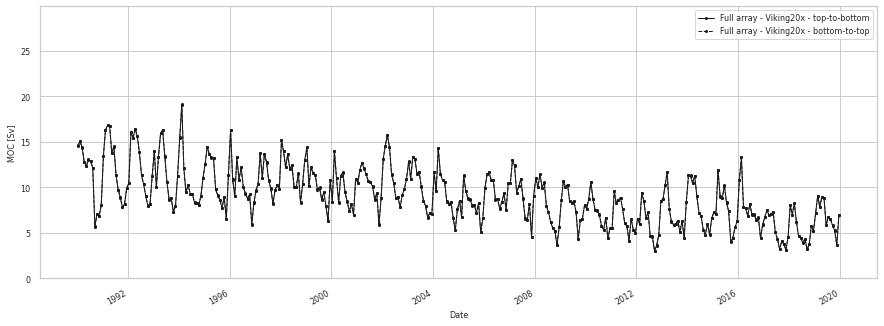

In [52]:
plot_amoc_upvsdown_timeseries(amoc_osnap_sumup-amoc_davis_sumup-amoc_hudso_sumup,
                             amoc_osnap_sumdown-amoc_davis_sumdown-amoc_hudso_sumdown)

## If we sum these data from low to high density again -- a second integral -- this gives us the overturning component of the northwards flux of density.

I think that formally this is only true if there is no net flow. Look at the equations to see if I can correct for this net flow somehow.

These numbers are largely negative as light water north and heavy water south are both negative northward density fluxes.

In [53]:
amoc_osnap_sumdown_sumdown=(amoc_osnap_sumdown.cumsum(dim="vosigma0_bin",keep_attrs=True)
                            -amoc_osnap_sumdown.sum(dim="vosigma0_bin",keep_attrs=True))
amoc_davis_sumdown_sumdown=(amoc_davis_sumdown.cumsum(dim="vosigma0_bin",keep_attrs=True)
                              -amoc_davis_sumdown.sum(dim="vosigma0_bin",keep_attrs=True))
amoc_hudso_sumdown_sumdown=(amoc_hudso_sumdown.cumsum(dim="vosigma0_bin",keep_attrs=True)
                              -amoc_hudso_sumdown.sum(dim="vosigma0_bin",keep_attrs=True))





In [54]:
amoc_osnap_sumdown_sumdown.attrs["long_name"]='Northward mass flux'
amoc_osnap_sumdown_sumdown.attrs["units"]='Gg s$^{-1}$'
amoc_davis_sumdown_sumdown.attrs["long_name"]='Northward mass flux'
amoc_davis_sumdown_sumdown.attrs["units"]='Gg s$^{-1}$'
amoc_hudso_sumdown_sumdown.attrs["long_name"]='Northward mass flux'
amoc_hudso_sumdown_sumdown.attrs["units"]='Gg s$^{-1}$'


In [55]:
def plot_mass_flux(amoc_sumdown_sumdown):
    fig, ax = plt.subplots(2,1,figsize=(5,15),gridspec_kw={'hspace': 0.01, 'wspace': 0.1,'height_ratios': [1, 4]})
    plt.tight_layout()
    amoc_sumdown_sumdown.plot.line(ax=ax[0],y="vosigma0_bin",add_legend=False,color='darkgrey',linewidth=0.4);
    amoc_sumdown_sumdown.mean(dim='time_counter',keep_attrs=True).plot.line(ax=ax[0],y="vosigma0_bin",add_legend=False,color='k',linewidth=1.4);

    amoc_sumdown_sumdown.plot.line(ax=ax[1],y="vosigma0_bin",add_legend=False,color='darkgrey',linewidth=0.4);
    amoc_sumdown_sumdown.mean(dim='time_counter',keep_attrs=True).plot.line(ax=ax[1],y="vosigma0_bin",add_legend=False,color='k',linewidth=1.4);



    ax[0].set_ylim([24.5,26.5])
    ax[1].set_ylim([26.5,28.0])
    ax[0].set_xlim([-500,200])
    ax[1].set_xlim([-500,200])
    ax[0].set_title('Full array')
    ax[0].invert_yaxis()
    ax[1].invert_yaxis()

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for axis in ax.flat:
        axis.label_outer()


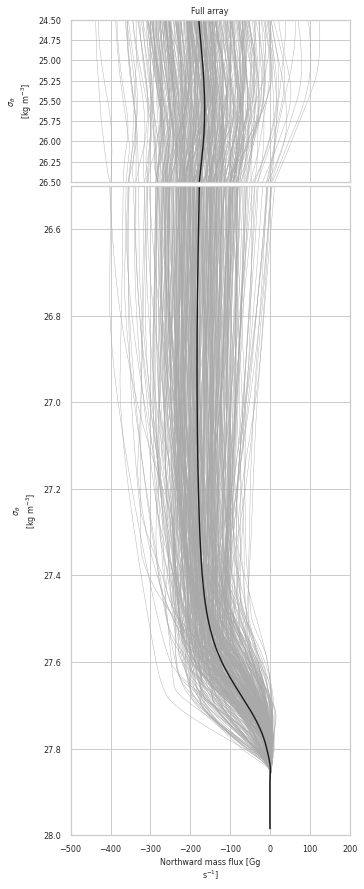

In [56]:
plot_mass_flux(amoc_osnap_sumdown_sumdown-amoc_davis_sumdown_sumdown-amoc_hudso_sumdown_sumdown)

### and a time series 

I've plotted this for sig_0 >= 27.0 rather than over whole column because of the problematic mean flow.

In [57]:
def plot_density_flux_timeseries():
    fig, ax = plt.subplots(figsize=(15,5))
    ((amoc_osnap_sumdown_sumdown-amoc_davis_sumdown_sumdown-amoc_hudso_sumdown_sumdown).isel(vosigma0_bin=149)
        .plot.line(x="time_counter",marker='o',ms=2,linewidth=1,color='k',label='Full array'))
    
    ax.set_ylim([250,-500])
    return

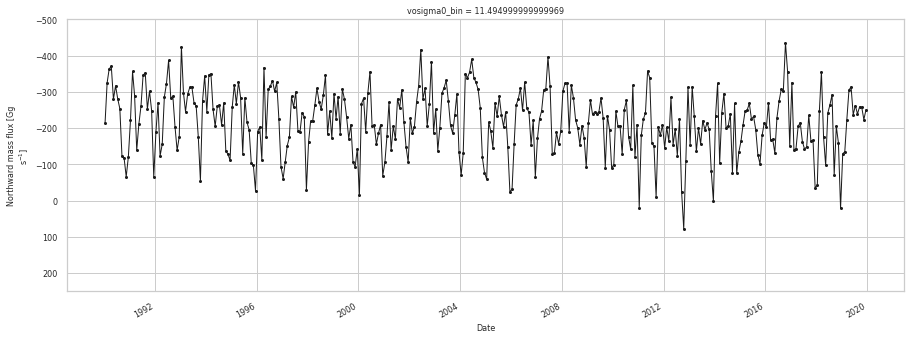

In [58]:
plot_density_flux_timeseries()

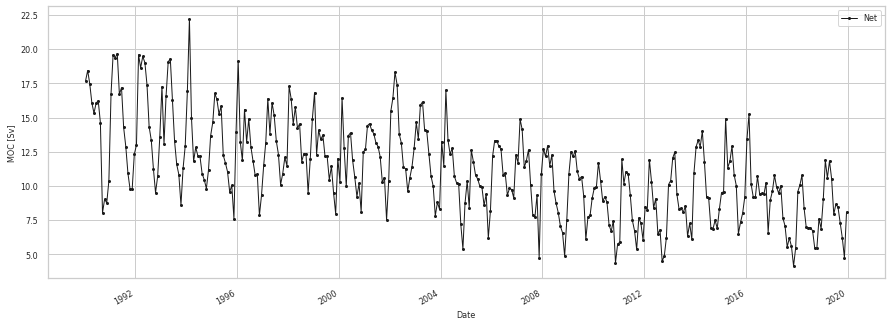

In [59]:
plot_amoc_timeseries(amoc_osnap_sumdown,amoc_davis_sumdown,amoc_hudso_sumdown)

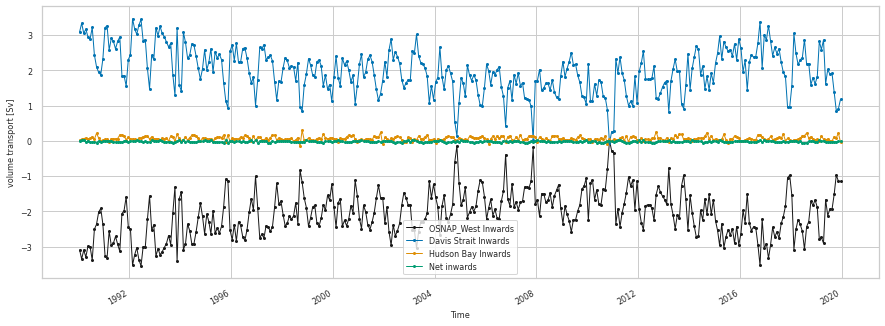

In [60]:
plot_transport_timeseries()

### some labrador current calculations

In [61]:
amoc_osnap_lss = calculate_amoc(section_osnap.isel(c=slice(  0,250,1)))
amoc_osnap_lss_sumup=amoc_osnap_lss.cumsum(dim="vosigma0_bin")
amoc_osnap_lss_sumdown=(amoc_osnap_lss.cumsum(dim="vosigma0_bin",keep_attrs=True)
                      -amoc_osnap_lss.sum(dim="vosigma0_bin",keep_attrs=True))
amoc_osnap_lss_annualmean = amoc_osnap_lss.groupby(amoc_osnap_lss.time_counter.dt.year).mean()
amoc_osnap_lss_sumup_annualmean = amoc_osnap_lss_sumup.groupby(amoc_osnap_lss_sumup.time_counter.dt.year).mean()
amoc_osnap_lss_sumdown_annualmean = amoc_osnap_lss_sumdown.groupby(amoc_osnap_lss_sumdown.time_counter.dt.year).mean()

amoc_osnap_lsn = calculate_amoc(section_osnap.isel(c=slice(250,500,1)))
amoc_osnap_lsn_sumup=amoc_osnap_lsn.cumsum(dim="vosigma0_bin")
amoc_osnap_lsn_sumdown=(amoc_osnap_lsn.cumsum(dim="vosigma0_bin",keep_attrs=True)
                      -amoc_osnap_lsn.sum(dim="vosigma0_bin",keep_attrs=True))
amoc_osnap_lsn_annualmean = amoc_osnap_lsn.groupby(amoc_osnap_lsn.time_counter.dt.year).mean()
amoc_osnap_lsn_sumup_annualmean = amoc_osnap_lsn_sumup.groupby(amoc_osnap_lsn_sumup.time_counter.dt.year).mean()
amoc_osnap_lsn_sumdown_annualmean = amoc_osnap_lsn_sumdown.groupby(amoc_osnap_lsn_sumdown.time_counter.dt.year).mean()

amoc_osnap_annualmean = amoc_osnap.groupby(amoc_osnap.time_counter.dt.year).mean()
amoc_osnap_sumup_annualmean = amoc_osnap_sumup.groupby(amoc_osnap_sumup.time_counter.dt.year).mean()
amoc_osnap_sumdown_annualmean = amoc_osnap_sumdown.groupby(amoc_osnap_sumdown.time_counter.dt.year).mean()
amoc_davis_annualmean = amoc_davis.groupby(amoc_davis.time_counter.dt.year).mean()
amoc_davis_sumup_annualmean = amoc_davis_sumup.groupby(amoc_davis_sumup.time_counter.dt.year).mean()
amoc_davis_sumdown_annualmean = amoc_davis_sumdown.groupby(amoc_davis_sumdown.time_counter.dt.year).mean()
amoc_hudso_annualmean = amoc_hudso.groupby(amoc_hudso.time_counter.dt.year).mean()
amoc_hudso_sumup_annualmean = amoc_hudso_sumup.groupby(amoc_hudso_sumup.time_counter.dt.year).mean()
amoc_hudso_sumdown_annualmean = amoc_hudso_sumdown.groupby(amoc_hudso_sumdown.time_counter.dt.year).mean()


In [62]:
def plot_amoc_lc(osnap_sum):
    fig, ax = plt.subplots(2,1,figsize=(5,12),gridspec_kw={'hspace': 0.01,'height_ratios': [1, 4]})
    plt.tight_layout()

# split plot vertically to emphasise the higher density levels

# lower density section
    
    (osnap_sum
        .plot.line(ax=ax[0],y="vosigma0_bin",add_legend=False,color='darkgrey',linewidth=0.4))
    (osnap_sum
         .mean(dim='time_counter')
         .plot.line(ax=ax[0],y="vosigma0_bin",add_legend=False,color='k',linewidth=1.4))


# higher density section
    (osnap_sum
         .plot.line(ax=ax[1],y="vosigma0_bin",add_legend=False,color='darkgrey',linewidth=0.4))
    (osnap_sum
         .mean(dim='time_counter')
         .plot.line(ax=ax[1],y="vosigma0_bin",add_legend=False,color='k',linewidth=1.4))    

# add maxima to mean curve
    def amoc_max(amoc):
        return (amoc.mean(dim='time_counter')
            .isel(vosigma0_bin=amoc.mean(dim='time_counter').argmax(dim="vosigma0_bin")))
    
    osnap_max = amoc_max(osnap_sum)

    ax[1].scatter(osnap_max.data,osnap_max.vosigma0_bin.data,color='C1',zorder=10)

# set up axes
    ax[0].set_ylim([27,24.5])
    ax[0].set_xlim([-5,50])
    ax[0].set_title('Full array')

    ax[1].set_ylim([28,27])
    ax[1].set_xlim([-5,50])
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for axis in ax.flat:
        axis.label_outer()

    # plt.savefig('Viking20x_OSNAP_overturning_streamfunction_2014-18.png')
    return

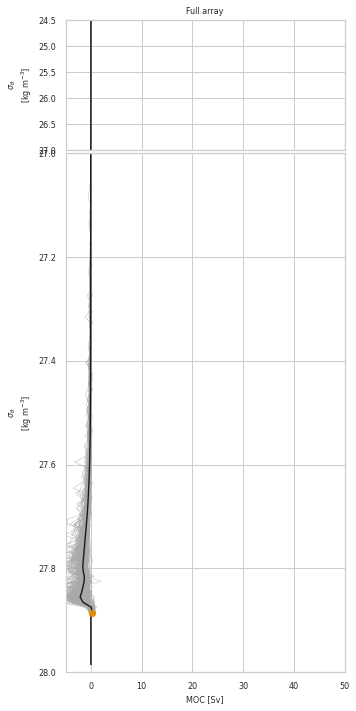

In [63]:
plot_amoc_lc(amoc_osnap_lss)

In [67]:
def plot_amoc_lc_annual(osnap_sum,title_text):
    sns.set_palette("Spectral",30)
    fig, ax = plt.subplots(2,1,figsize=(6,9),gridspec_kw={'hspace': 0.01,'height_ratios': [1, 4]})
    plt.tight_layout()

# split plot vertically to emphasise the higher density levels

# lower density section
    
    (osnap_sum
        .plot.line(ax=ax[0],y="vosigma0_bin",add_legend=False,linewidth=1.4))


# higher density section
    fig1 = (osnap_sum
         .plot.line(ax=ax[1],y="vosigma0_bin",add_legend=False,linewidth=1.4))

# set up axes
    ax[0].set_ylim([26.99,10])
#     ax[0].set_xlim([-1,1])
    ax[0].set_title(title_text)

    ax[1].set_ylim([28,27])
#     ax[1].set_xlim([-1,1])
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for axis in ax.flat:
        axis.label_outer()
        
    lgd = ax[1].legend(labels=osnap_sum.year.data,bbox_to_anchor=[1,0],loc='lower left',)

    plt.savefig('LC_outflow.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
    return

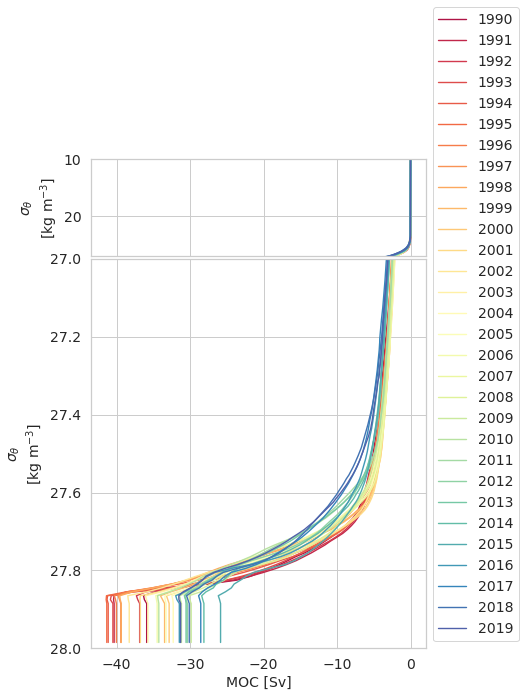

In [68]:
plot_amoc_lc_annual(amoc_osnap_lss_sumup_annualmean,'')

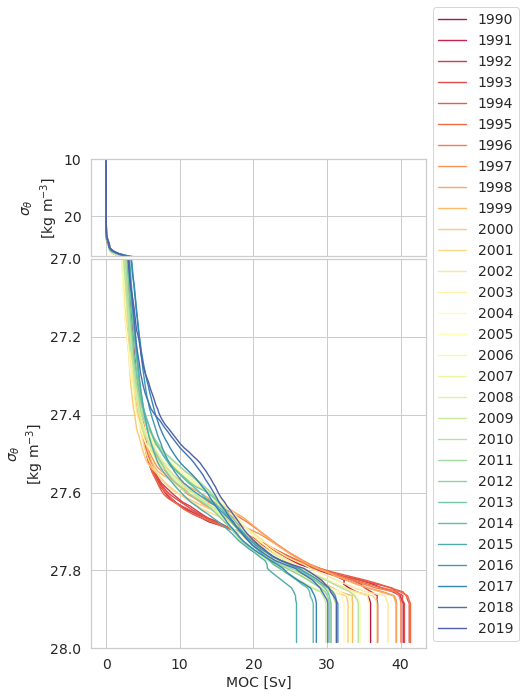

In [69]:
plot_amoc_lc_annual(amoc_osnap_lsn_sumup_annualmean-
                    amoc_davis_sumup_annualmean-
                    amoc_hudso_sumup_annualmean
                    ,'')

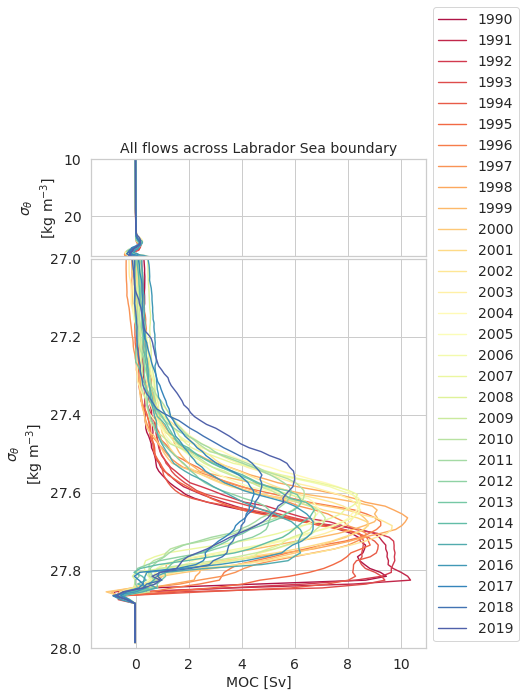

In [70]:
plot_amoc_lc_annual(amoc_osnap_sumup_annualmean-amoc_davis_sumup_annualmean-amoc_hudso_sumup_annualmean,'All flows across Labrador Sea boundary')

In [71]:
amoc_osnap_sumdown.vosigma0_bin[598]


<xarray.DataArray 'vosigma0_bin' ()>
array(15.985)
Coordinates:
    vosigma0_bin  float64 15.98
Attributes:
    long_name:  $\sigma_{\theta}$
    units:      $\mathrm{kg\ m^{-3}}$

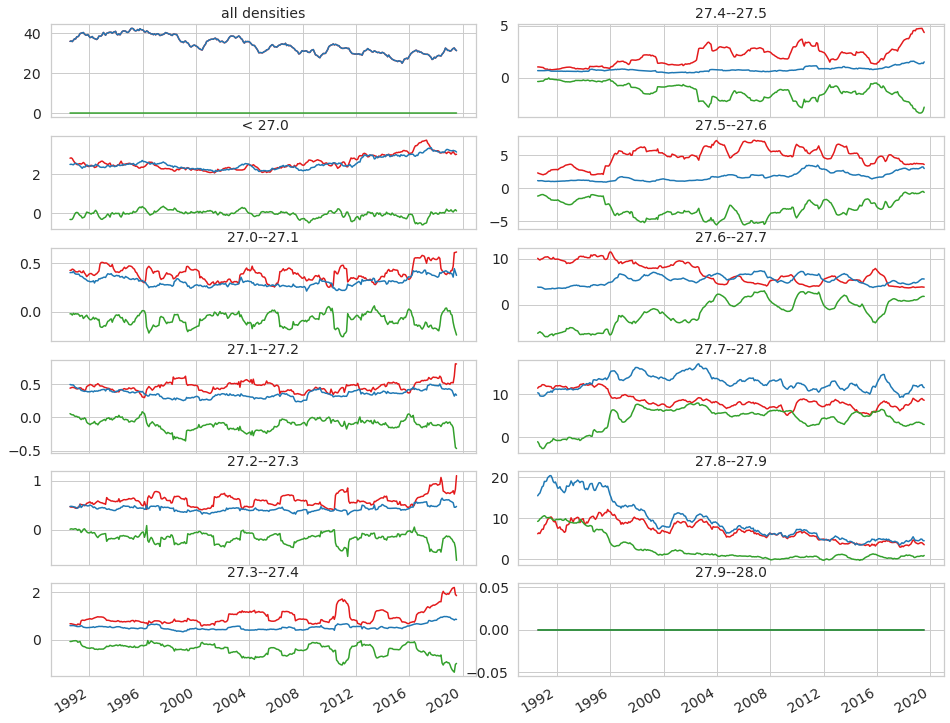

In [72]:
sns.set_palette("Paired",12)

fig,ax = plt.subplots(6,2,figsize=(16,12),sharex=True,gridspec_kw={'hspace': 0.2,'wspace': 0.1})
plt.tight_layout()

outflow = amoc_osnap_lss_sumup
inflow = amoc_osnap_lsn_sumup - amoc_davis_sumup - amoc_hudso_sumup


def plot_by_density_range(ax,inflow,outflow,title):
    converted = -1* (inflow + outflow)
    outflow = -1 * outflow
    
#     inflow.plot(ax=ax,label='volume inflow',color='C4')
#     outflow.plot(ax=ax,label='volume outflow',color='C0')
#     converted.plot(ax=ax,label='volume converted',color='C2')

    inflow.rolling(time_counter=12, center=True).mean().plot(ax=ax,label='volume inflow',color='C5')
    outflow.rolling(time_counter=12, center=True).mean().plot(ax=ax,label='volume outflow',color='C1')
    converted.rolling(time_counter=12, center=True).mean().plot(ax=ax,label='volume converted',color='C3')

    ax.set_xlabel('')

    ax.set_ylabel('')
    ax.set_ylabel('')

    ax.set_title(title)

    
plot_by_density_range(ax[0,0],
                      (inflow.isel(vosigma0_bin=-1)
                      -inflow.isel(vosigma0_bin=0)),   
                      (outflow.isel(vosigma0_bin=-1)
                      -outflow.isel(vosigma0_bin=0)),
                      'all densities')
plot_by_density_range(ax[1,0],
                      (inflow.isel(vosigma0_bin=1700)
                      -inflow.isel(vosigma0_bin=0)),   
                      (outflow.isel(vosigma0_bin=1700)
                      -outflow.isel(vosigma0_bin=0)),
                      ' < 27.0'  )
plot_by_density_range(ax[2,0],
                      (inflow.isel(vosigma0_bin=1710)
                      -inflow.isel(vosigma0_bin=1700)),   
                      (outflow.isel(vosigma0_bin=1710)
                      -outflow.isel(vosigma0_bin=1700)),
                      '27.0--27.1'  )
plot_by_density_range(ax[3,0],
                      (inflow.isel(vosigma0_bin=1720)
                      -inflow.isel(vosigma0_bin=1710)),   
                      (outflow.isel(vosigma0_bin=1720)
                      -outflow.isel(vosigma0_bin=1710)),
                      '27.1--27.2'  )
plot_by_density_range(ax[4,0],
                      (inflow.isel(vosigma0_bin=1730)
                      -inflow.isel(vosigma0_bin=1720)),   
                      (outflow.isel(vosigma0_bin=1730)
                      -outflow.isel(vosigma0_bin=1720)),
                      '27.2--27.3'  )
plot_by_density_range(ax[5,0],
                      (inflow.isel(vosigma0_bin=1740)
                      -inflow.isel(vosigma0_bin=1730)),   
                      (outflow.isel(vosigma0_bin=1740)
                      -outflow.isel(vosigma0_bin=1730)),
                      '27.3--27.4'  )
plot_by_density_range(ax[0,1],
                      (inflow.isel(vosigma0_bin=1750)
                      -inflow.isel(vosigma0_bin=1740)),   
                      (outflow.isel(vosigma0_bin=1750)
                      -outflow.isel(vosigma0_bin=1740)),
                      '27.4--27.5'  )
plot_by_density_range(ax[1,1],
                      (inflow.isel(vosigma0_bin=1760)
                      -inflow.isel(vosigma0_bin=1750)),   
                      (outflow.isel(vosigma0_bin=1760)
                      -outflow.isel(vosigma0_bin=1750)),
                      '27.5--27.6'  )
plot_by_density_range(ax[2,1],
                      (inflow.isel(vosigma0_bin=1770)
                      -inflow.isel(vosigma0_bin=1760)),   
                      (outflow.isel(vosigma0_bin=1770)
                      -outflow.isel(vosigma0_bin=1760)),
                      '27.6--27.7'  )
plot_by_density_range(ax[3,1],
                      (inflow.isel(vosigma0_bin=1780)
                      -inflow.isel(vosigma0_bin=1770)),   
                      (outflow.isel(vosigma0_bin=1780)
                      -outflow.isel(vosigma0_bin=1770)),
                      '27.7--27.8'  )
plot_by_density_range(ax[4,1],
                      (inflow.isel(vosigma0_bin=1790)
                      -inflow.isel(vosigma0_bin=1780)),   
                      (outflow.isel(vosigma0_bin=1790)
                      -outflow.isel(vosigma0_bin=1780)),
                      '27.8--27.9'  )
plot_by_density_range(ax[5,1],
                      (inflow.isel(vosigma0_bin=-1)
                      -inflow.isel(vosigma0_bin=1790)),   
                      (outflow.isel(vosigma0_bin=-1)
                      -outflow.isel(vosigma0_bin=1790)),
                      '27.9--28.0'  )

plt.savefig(path_figures / 'test.png')
    

In [73]:
amoc_osnap_lss_sumup

<xarray.DataArray 'histogram_vosigma0' (time_counter: 360, vosigma0_bin: 1799)>
array([[  0.        ,   0.        ,   0.        , ..., -40.8909216 ,
        -40.8909216 , -40.8909216 ],
       [  0.        ,   0.        ,   0.        , ..., -43.23663813,
        -43.23663813, -43.23663813],
       [  0.        ,   0.        ,   0.        , ..., -29.85536774,
        -29.85536774, -29.85536774],
       ...,
       [  0.        ,   0.        ,   0.        , ..., -30.48476857,
        -30.48476857, -30.48476857],
       [  0.        ,   0.        ,   0.        , ..., -28.24486345,
        -28.24486345, -28.24486345],
       [  0.        ,   0.        ,   0.        , ..., -29.65231609,
        -29.65231609, -29.65231609]])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1990-01-16T12:00:00 ... 2019-...
  * vosigma0_bin  (vosigma0_bin) float64 10.0 10.02 10.02 ... 27.96 27.97 27.98
Attributes:
    long_name:  MOC
    units:      Sv

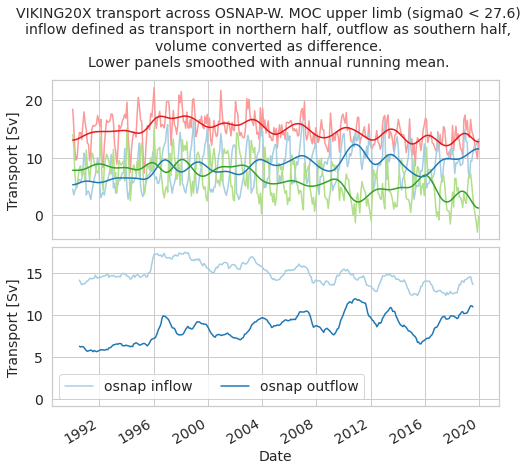

In [74]:

sns.set_palette("Paired",12)

fig,ax = plt.subplots(2,1,figsize=(8,6),sharex=True,gridspec_kw={'hspace': 0.05,'height_ratios': [1,1]})
plt.tight_layout()



inflow = ((amoc_osnap_lsn_sumup.isel(vosigma0_bin=1770) -
           amoc_davis_sumup.isel(vosigma0_bin=1770) -
           amoc_hudso_sumup.isel(vosigma0_bin=1770)) - 
          (amoc_osnap_lsn_sumup.isel(vosigma0_bin=1730) -
           amoc_davis_sumup.isel(vosigma0_bin=1730) -
           amoc_hudso_sumup.isel(vosigma0_bin=1730)))
outflow = ((-1*(amoc_osnap_lss_sumup.isel(vosigma0_bin=1770))) - 
           (-1*(amoc_osnap_lss_sumup.isel(vosigma0_bin=1730))))
converted = inflow - outflow

inflow.plot(ax=ax[0],label='volume inflow',color='C4')
outflow.plot(ax=ax[0],label='volume outflow',color='C0')
converted.plot(ax=ax[0],label='volume converted',color='C2')

outflow_mean = outflow.mean()
inflow_mean = inflow.mean()
converted_mean = converted.mean()

outflow_filtered = xr.apply_ufunc(butter_lowpass_filtfilt, outflow-outflow_mean,cutoff,fs,
                     dask='parallelized')
inflow_filtered = xr.apply_ufunc(butter_lowpass_filtfilt, inflow-inflow_mean,cutoff,fs,
                     dask='parallelized')
converted_filtered = xr.apply_ufunc(butter_lowpass_filtfilt, converted-converted_mean,cutoff,fs,
                     dask='parallelized')

(inflow_filtered+inflow_mean).plot(ax=ax[0],label='volume inflow',color='C5')
(outflow_filtered+outflow_mean).plot(ax=ax[0],label='volume outflow',color='C1')
(converted_filtered+converted_mean).plot(ax=ax[0],label='volume converted',color='C3')
inflow.rolling(time_counter=12, center=True).mean().plot(ax=ax[1],label='osnap inflow')
outflow.rolling(time_counter=12, center=True).mean().plot(ax=ax[1],label='osnap outflow')

ax[1].set_ylim(bottom=-0.9)
ax[0].set_xlabel('')

ax[0].set_ylabel('Transport [Sv]')
ax[1].set_ylabel('Transport [Sv]')


ax[0].set_title('')
ax[1].set_title('')
lgd = ax[1].legend(ncol = 3)

title = plt.suptitle('VIKING20X transport across OSNAP-W. MOC upper limb (sigma0 < 27.6)\n' +
                     'inflow defined as transport in northern half, outflow as southern half,\n' + 
                     'volume converted as difference.\n' +
                     'Lower panels smoothed with annual running mean.',size='medium',y=1.05)

plt.savefig('osnap_w_inflow_outflow.png', bbox_extra_artists=(lgd,title), bbox_inches='tight')


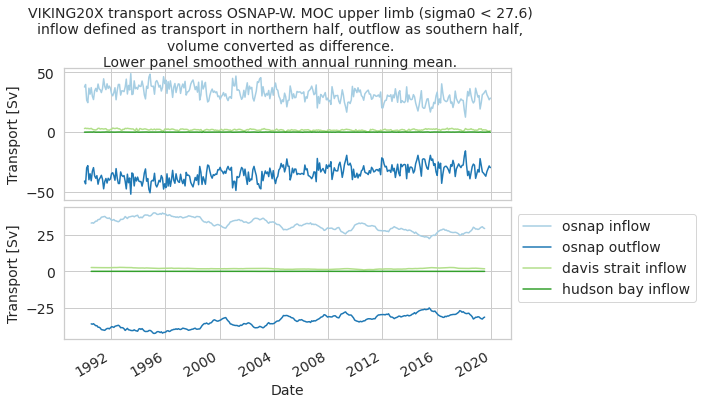

In [75]:
fig,ax = plt.subplots(2,1,figsize=(8,5),sharex=True,gridspec_kw={'hspace': 0.05,'height_ratios': [1, 1]})
plt.tight_layout()

sns.set_palette("colorblind",10)

inflow  = (amoc_osnap_lsn_sumup.isel(vosigma0_bin=-1)-
           amoc_osnap_lsn_sumup.isel(vosigma0_bin=0))
outflow  = (amoc_osnap_lss_sumup.isel(vosigma0_bin=-1)-
           amoc_osnap_lss_sumup.isel(vosigma0_bin=0))
davisflow =   ((-1* (amoc_davis_sumup.isel(vosigma0_bin=-1)))-
             (-1* (amoc_davis_sumup.isel(vosigma0_bin=0))))
hudsonflow = ((-1* (amoc_hudso_sumup.isel(vosigma0_bin=-1)))-
             (-1* (amoc_hudso_sumup.isel(vosigma0_bin=0))))

inflow.plot(ax=ax[0],label='osnap inflow')
outflow.plot(ax=ax[0],label='osnap outflow')
davisflow.plot(ax=ax[0],label='davis strait inflow')
hudsonflow.plot(ax=ax[0],label='hudson bay inflow')

inflow.rolling(time_counter=12, center=True).mean().plot(ax=ax[1],label='osnap inflow')
outflow.rolling(time_counter=12, center=True).mean().plot(ax=ax[1],label='osnap outflow')
davisflow.rolling(time_counter=12, center=True).mean().plot(ax=ax[1],label='davis strait inflow')
hudsonflow.rolling(time_counter=12, center=True).mean().plot(ax=ax[1],label='hudson bay inflow')

# ax[1].set_ylim(bottom=-0.9)
ax[0].set_xlabel('')
ax[1].set_xlabel('Date')

ax[0].set_ylabel('Transport [Sv]')
ax[1].set_ylabel('Transport [Sv]')

ax[0].set_title('')
ax[1].set_title('')


lgd = ax[1].legend(bbox_to_anchor=(1,1))

title = plt.suptitle('VIKING20X transport across OSNAP-W. MOC upper limb (sigma0 < 27.6)\n' +
                     'inflow defined as transport in northern half, outflow as southern half,\n' + 
                     'volume converted as difference.\n' +
                     'Lower panel smoothed with annual running mean.',size='medium',y=1.05)

plt.savefig('osnap_w_inflow_outflow.png', bbox_extra_artists=(lgd,title), bbox_inches='tight')


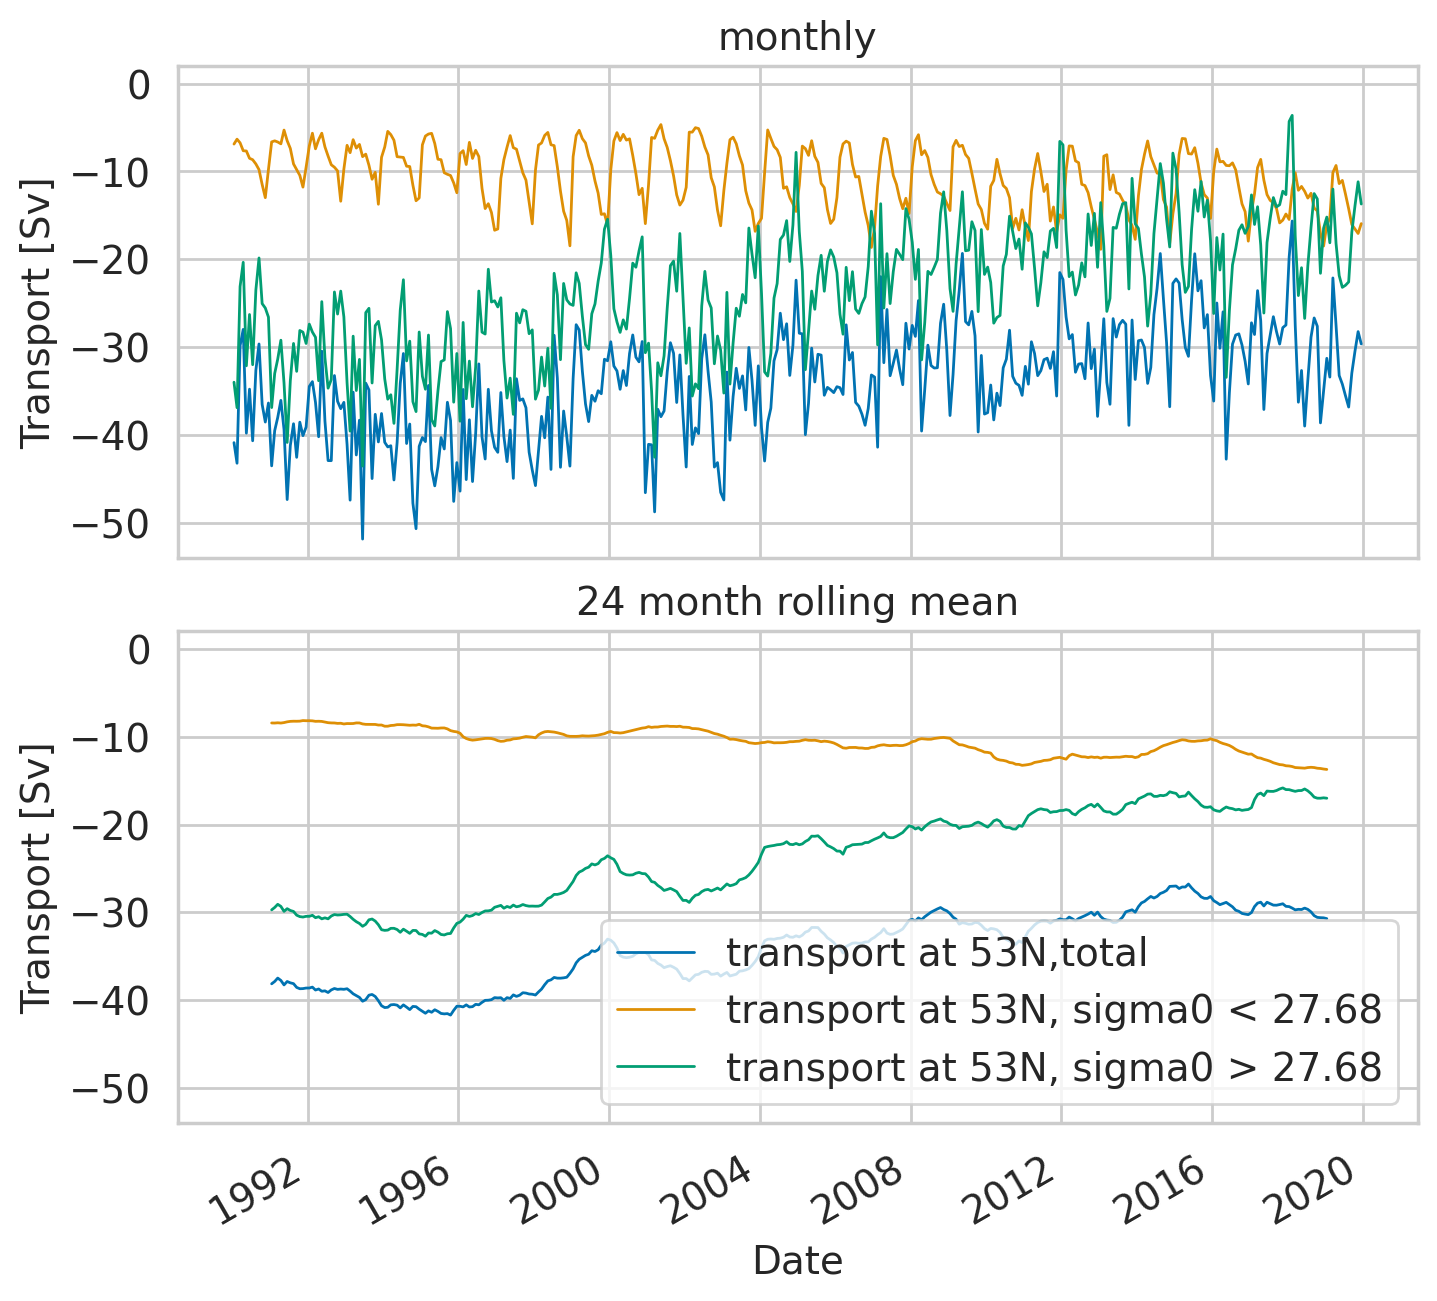

In [76]:
fig,ax = plt.subplots(2,1,figsize=(8,7),sharex=True,gridspec_kw={'hspace': 0.15,'height_ratios': [1, 1]},dpi=200)
plt.tight_layout()

sns.set_palette("colorblind",10)

outflow_tota  = (amoc_osnap_lss_sumup.isel(vosigma0_bin=-1)-
           amoc_osnap_lss_sumup.isel(vosigma0_bin=0))
outflow_surf  = (amoc_osnap_lss_sumup.isel(vosigma0_bin=1768)-
           amoc_osnap_lss_sumup.isel(vosigma0_bin=0))
outflow_deep  = (amoc_osnap_lss_sumup.isel(vosigma0_bin=-1)-
           amoc_osnap_lss_sumup.isel(vosigma0_bin=1768))

outflow_tota.plot(ax=ax[0],linewidth = 1,label='transport at 53N, total')
outflow_surf.plot(ax=ax[0],linewidth = 1,label='transport at 53N, sigma0 < 27.68')
outflow_deep.plot(ax=ax[0],linewidth = 1,label='transport at 53N, sigma0 > 27.68')

outflow_tota.rolling(time_counter=24, center=True).mean().plot(ax=ax[1],linewidth = 1,label='transport at 53N,total')
outflow_surf.rolling(time_counter=24, center=True).mean().plot(ax=ax[1],linewidth = 1,label='transport at 53N, sigma0 < 27.68')
outflow_deep.rolling(time_counter=24, center=True).mean().plot(ax=ax[1],linewidth = 1,label='transport at 53N, sigma0 > 27.68')

ax[0].set_ylim(-54,2)
ax[1].set_ylim(-54,2)
ax[0].set_xlabel('')
ax[1].set_xlabel('Date')

ax[0].set_ylabel('Transport [Sv]')
ax[1].set_ylabel('Transport [Sv]')

ax[0].set_title('monthly')
ax[1].set_title('24 month rolling mean')

ax[1].legend()

# title = plt.suptitle('VIKING20X transport across OSNAP-W. MOC upper limb (sigma0 < 27.6)\n' +
#                      'inflow defined as transport in northern half, outflow as southern half,\n' + 
#                      'volume converted as difference.\n' +
#                      'Lower panel smoothed with annual running mean.',size='medium',y=1.05)

plt.savefig('osnap_w_outflow_53N.png', bbox_inches='tight')


In [77]:
amoc_osnap_lss_sumup.vosigma0_bin[1768]


<xarray.DataArray 'vosigma0_bin' ()>
array(27.685)
Coordinates:
    vosigma0_bin  float64 27.68
Attributes:
    long_name:  $\sigma_{\theta}$
    units:      $\mathrm{kg\ m^{-3}}$

## Read in heat and freshwater flux terms

In [78]:
heat_flux_sigma_annualmean= xr.open_dataarray(path_data_output / 'heat_flux_sigma_annualmean.nc')
heat_flux_sigma= xr.open_dataarray(path_data_output / 'heat_flux_sigma.nc')
freshwater_flux_sigma_annualmean= xr.open_dataarray(path_data_output / 'freshwater_flux_sigma_annualmean.nc')
freshwater_flux_sigma= xr.open_dataarray(path_data_output / 'freshwater_flux_sigma.nc')


In [79]:
heat_flux_sigma_annualmean = heat_flux_sigma_annualmean.rename({'sosigma0_bin':'vosigma0_bin'})
heat_flux_sigma = heat_flux_sigma.rename({'sosigma0_bin':'vosigma0_bin'})
freshwater_flux_sigma_annualmean = freshwater_flux_sigma_annualmean.rename({'sosigma0_bin':'vosigma0_bin'})
freshwater_flux_sigma = freshwater_flux_sigma.rename({'sosigma0_bin':'vosigma0_bin'})

In [80]:
# filter

heat_flux_sigma_filtered = xr.apply_ufunc(butter_lowpass_filtfilt, heat_flux_sigma,cutoff,fs,
                        input_core_dims=(["vosigma0_bin","time_counter"],[],[]),  # list with one entry per arg
                        output_core_dims=[["vosigma0_bin","time_counter"]],  # returned data has 3 dimension
                     dask='parallelized')

freshwater_flux_sigma_filtered = xr.apply_ufunc(butter_lowpass_filtfilt, freshwater_flux_sigma,cutoff,fs,
                        input_core_dims=(["vosigma0_bin","time_counter"],[],[]),  # list with one entry per arg
                        output_core_dims=[["vosigma0_bin","time_counter"]],  # returned data has 3 dimension
                     dask='parallelized')




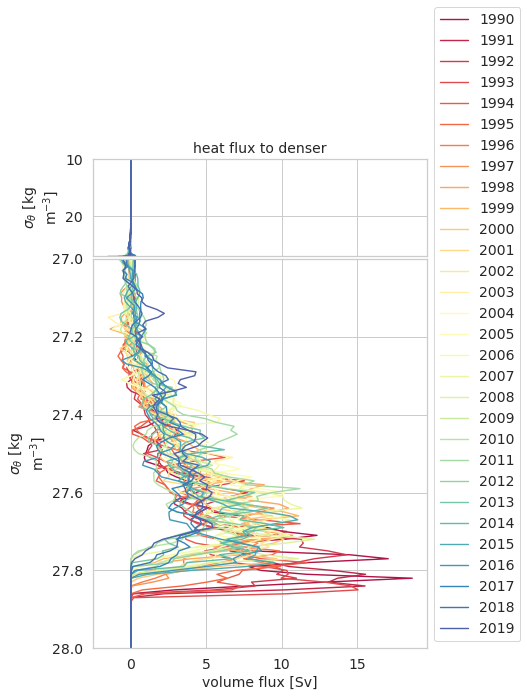

In [81]:
plot_amoc_lc_annual(heat_flux_sigma_annualmean,'heat flux to denser')

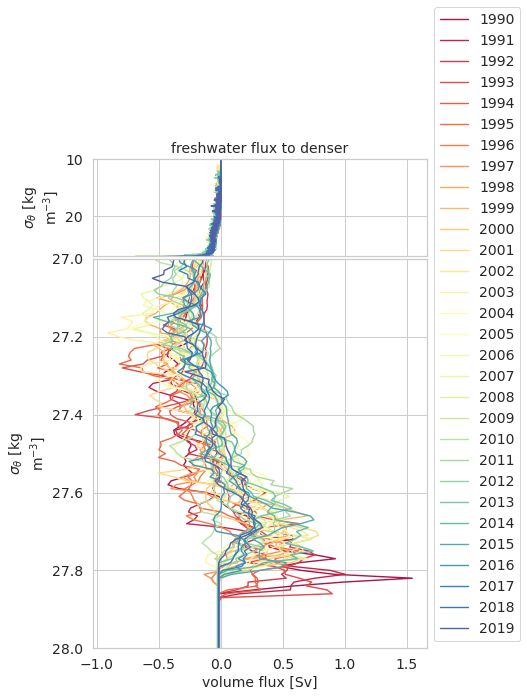

In [82]:
plot_amoc_lc_annual(freshwater_flux_sigma_annualmean,'freshwater flux to denser')

## Read in volume tendency terms

In [83]:
vcdata_path = project_path / path_data_section / "watermassBudget" / "volumeChange" 

In [84]:
volume_by_sigma = xr.open_dataarray(vcdata_path / 'volume_by_sigma.nc')

In [85]:
dVbydt = volume_by_sigma.rolling(time_counter=2).mean()

In [86]:
dVbydt = dVbydt.diff(dim='time_counter',n=1,label='lower')

In [87]:
dVbydt = dVbydt / (1.0e06*365.0 * 24.0 * 3600.0 / 12.0)
dVbydt = dVbydt.rename({'pot_dens_bin':'vosigma0_bin'})

In [88]:
dVbydt["vosigma0_bin"] = dVbydt.vosigma0_bin - 1000.0

In [91]:
dVbydt

<xarray.DataArray 'histogram_pot_dens' (time_counter: 359, vosigma0_bin: 1799)>
array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.19568158e-05,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -5.61490849e-05,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1990-01-16T12:00:00 ... 2019-...
  * vosigma0_bin  (vosigma0_bin) float64 10.0 10.01 10.02 ... 27.96 27.97 27.98
Attributes:
    long_name:  volume
    units:      m$^3$

In [111]:
amoc_osnap.vosigma0_bin

<xarray.DataArray 'vosigma0_bin' (vosigma0_bin: 1799)>
array([10.005, 10.015, 10.025, ..., 27.965, 27.975, 27.985])
Coordinates:
  * vosigma0_bin  (vosigma0_bin) float64 10.0 10.02 10.02 ... 27.96 27.97 27.98
Attributes:
    long_name:  $\sigma_{\theta}$
    units:      $\mathrm{kg\ m^{-3}}$

In [98]:
# fix vosigma0_bin to match other datasets for combination
dVbydt["vosigma0_bin"] = heat_flux_sigma.vosigma0_bin.isel(vosigma0_bin=slice(0,-1,1))

#### accumulate from minimum density to give volume flux across isopycnal towards lower density

In [100]:
dVbydt_sigma = dVbydt.cumsum(dim='vosigma0_bin')

In [101]:
dVbydt_sigma_annualmean = dVbydt_sigma.groupby(dVbydt_sigma.time_counter.dt.year).mean()

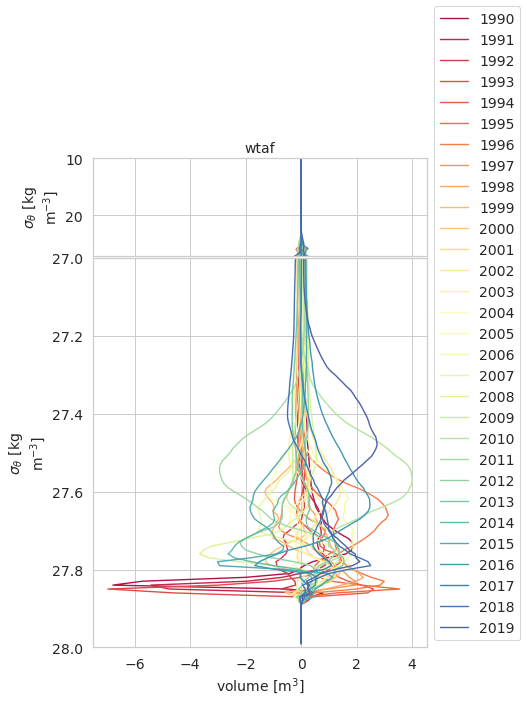

In [102]:
plot_amoc_lc_annual(dVbydt_sigma_annualmean,'wtaf')

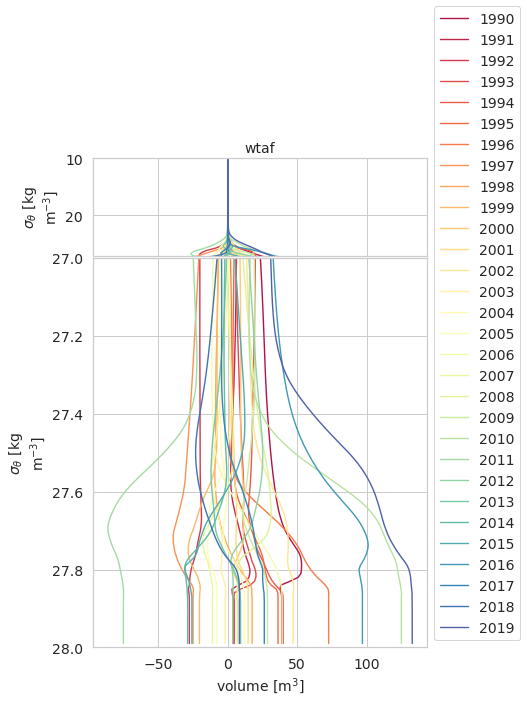

In [103]:
plot_amoc_lc_annual(dVbydt_sigma_annualmean.cumsum(dim='vosigma0_bin'),'wtaf')

## sum all terms (gives mixing component)

In [131]:
test = (amoc_osnap_sumup_annualmean
        - amoc_davis_sumup_annualmean
        - amoc_hudso_sumup_annualmean
        - heat_flux_sigma_annualmean.isel(vosigma0_bin=slice(0,-1,1)).load()
        - freshwater_flux_sigma_annualmean.isel(vosigma0_bin=slice(0,-1,1)).load()
        - dVbydt_sigma_annualmean
       )

In [144]:
amoc_osnap_sumup_annualmean.vosigma0_bin

<xarray.DataArray 'vosigma0_bin' (vosigma0_bin: 1799)>
array([10.005, 10.015, 10.025, ..., 27.965, 27.975, 27.985])
Coordinates:
  * vosigma0_bin  (vosigma0_bin) float64 10.0 10.02 10.02 ... 27.96 27.97 27.98
Attributes:
    long_name:  $\sigma_{\theta}$
    units:      $\mathrm{kg\ m^{-3}}$

ImportError: Plotting of arrays of cftime.datetime objects or arrays indexed by cftime.datetime objects requires the optional `nc-time-axis` (v1.2.0 or later) package.

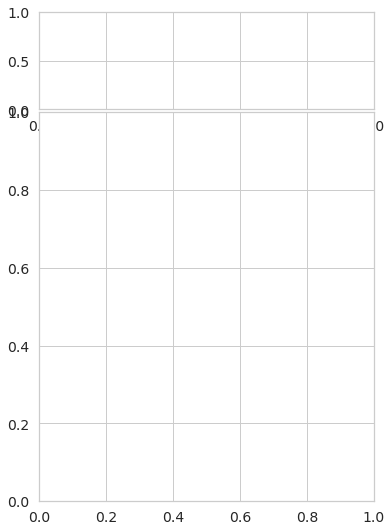

In [133]:
plot_amoc_lc_annual(test,'mixing?')

In [ ]:
plot_amoc_lc_annual(test.cumsum(dim='vosigma0_bin'),'mixing should sum to zero. wtf')

## Plot some time series to find out what is happening

#### start with sigma0 = 27.62 kg m$^{-3}$

In [ ]:
sigref = 10.0
sigsel = 27.65

isigsel = int((sigsel - sigref) * 100.0)

In [ ]:
def plot_time_series(fxs,colors,labels,title):
    sns.set(style="whitegrid")
    sns.set_palette("colorblind")

    fig,ax = plt.subplots(1,1,figsize=(8,4),sharex=True)
    plt.tight_layout()

    for ii,curve in enumerate(zip(fxs,colors,labels)):
        curve[0].plot(color=curve[1],label=curve[2],zorder=10-ii,linewidth = 1)

    # ax.set_ylim(bottom=0) 
    ax.set_xlabel('')
    ax.set_ylabel('volume flux [Sv]')
    ax.set_title(title)
    ax.legend()
    
    plt.savefig(project_path / path_figures / 'timeseries.png')
    
    return
    

In [ ]:
def plot_time_series_filtered(fxs,colors,labels,title):
    sns.set(style="whitegrid")
    sns.set_palette("colorblind")

    

    fxs_mean = [fx.mean() for fx in fxs]
    fxs_filtered = [xr.apply_ufunc(butter_lowpass_filtfilt, fx,cutoff,fs,
                         dask='parallelized') for fx in fxs]

    fig,ax = plt.subplots(2,1,figsize=(8,7),sharex=True)
    plt.tight_layout()

    for ii,curve in enumerate(zip(fxs[3:None],colors[3:None],labels[3:None])):
        curve[0].plot(ax=ax[0],color=curve[1],zorder=10-ii,linewidth = 1,alpha=0.5)
    for ii,curve in enumerate(zip(fxs_filtered[3:None],colors[3:None],labels[3:None])):
        curve[0].plot(ax=ax[0],color=curve[1],label=curve[2],zorder=10-ii,linewidth = 2)

    for ii,curve in enumerate(zip(fxs[0:4],colors[0:4],labels[0:4])):
        curve[0].plot(ax=ax[1],color=curve[1],zorder=10-ii,linewidth = 1,alpha=0.5)
    for ii,curve in enumerate(zip(fxs_filtered[0:4],colors[0:4],labels[0:4])):
        curve[0].plot(ax=ax[1],color=curve[1],label=curve[2],zorder=10-ii,linewidth = 2)

    # ax.set_ylim(bottom=0) 
    ax[0].set_xlabel('')
    ax[0].set_ylabel('volume flux [Sv]')
    ax[0].set_title('')
    ax[0].legend()
    ax[0].set_ylim(bottom=-4,top=25)
    # ax.set_ylim(bottom=0) 
    ax[1].set_xlabel('')
    ax[1].set_ylabel('volume flux [Sv]')
    ax[1].set_title('')
    ax[1].legend()
    ax[1].set_ylim(bottom=-45)
    
    plt.savefig(project_path / path_figures / 'watermass_timeseries.png',dpi=300, bbox_inches='tight')
    
    return
    

In [ ]:
tot_inflow = (amoc_osnap_lsn_sumup-
                  amoc_davis_sumup-
                  amoc_hudso_sumup)
net_inflow = (amoc_osnap_sumup-
                  amoc_davis_sumup-
                  amoc_hudso_sumup)
net_mixing = (net_inflow - 
              heat_flux_sigma -
              freshwater_flux_sigma - 
              dVbydt_sigma)


In [ ]:
plot_time_series([
#     dVbydt_sigma.isel(vosigma0_bin=isigsel),
#                   heat_flux_sigma.isel(vosigma0_bin=isigsel)-freshwater_flux_sigma.isel(vosigma0_bin=isigsel)-net_mixing.isel(vosigma0_bin=isigsel),
                  tot_inflow.isel(vosigma0_bin=isigsel),
                  -amoc_osnap_lss_sumup.isel(vosigma0_bin=isigsel),
                  net_inflow.isel(vosigma0_bin=isigsel)
                 ],
                 ['tab:red','b','k'],
                 ['inflow','outflow','conversion and storage'],
                 'watermass balance 27.68')

In [ ]:
plot_time_series_filtered([
    dVbydt_sigma.isel(vosigma0_bin=isigsel),
                  -heat_flux_sigma.isel(vosigma0_bin=isigsel),
                  -freshwater_flux_sigma.isel(vosigma0_bin=isigsel),
                  net_inflow.isel(vosigma0_bin=isigsel),
                  tot_inflow.isel(vosigma0_bin=isigsel),
                  -amoc_osnap_lss_sumup.isel(vosigma0_bin=isigsel),
                 ],
                 ['C2','C3','C9','C0','C1','C4'],
                 ['volume tendency','surface heat flux','freshwater flux','net inflow','inflow','outflow'],
                 'watermass balance 27.68')

In [ ]:
cutoff = 0.1
plot_time_series([lowpass_filter(dVbydt_sigma.isel(vosigma0_bin=isigsel)),
                  lowpass_filter(-heat_flux_sigma.isel(vosigma0_bin=isigsel)),
                  lowpass_filter(-freshwater_flux_sigma.isel(vosigma0_bin=isigsel)),
                  lowpass_filter(tot_inflow.isel(vosigma0_bin=isigsel)),
                  lowpass_filter(amoc_osnap_lss_sumup.isel(vosigma0_bin=isigsel)),
                  lowpass_filter(-net_mixing.isel(vosigma0_bin=isigsel))],
                 ['k','C0','C1','C2','C3','C4'],
                 ['volume tendency','heat flux','freshwater flux','tot inflow','outflow','mixing'],
                 'watermass balance 27.65')

In [ ]:

((net_inflow.groupby(net_inflow.time_counter.dt.month).mean().isel(vosigma0_bin=isigsel))).plot()
((heat_flux_sigma.groupby(heat_flux_sigma.time_counter.dt.month).mean().isel(vosigma0_bin=isigsel))*(-1)).plot()
((freshwater_flux_sigma.groupby(freshwater_flux_sigma.time_counter.dt.month).mean().isel(vosigma0_bin=isigsel))*(-1)).plot()
((dVbydt_sigma.groupby(dVbydt_sigma.time_counter.dt.month).mean().isel(vosigma0_bin=isigsel))).plot()
((net_mixing.groupby(net_mixing.time_counter.dt.month).mean().isel(vosigma0_bin=isigsel))).plot()


In [ ]:
test = (heat_flux_sigma.groupby(heat_flux_sigma.time_counter.dt.month).mean().isel(vosigma0_bin=isigsel))

In [ ]:
freshwater_flux_sigma - test

In [ ]:
month_length = heat_flux_sigma.time_counter.dt.days_in_month

In [ ]:
month_length

In [ ]:
weights = month_length.groupby('time_counter.season') / month_length.groupby('time_counter.season').sum()


In [ ]:
weights

In [ ]:
heat_flux_sigma_weighted = (heat_flux_sigma * weights).groupby('time_counter.season').sum(dim='time_counter')


In [ ]:
heat_flux_sigma_weighted

In [ ]:
(heat_flux_sigma * weights).groupby('time_counter.month').sum(dim='time_counter').isel(vosigma0_bin=isigsel).plot()

In [ ]:
test = heat_flux_sigma.groupby('time_counter.season') - (heat_flux_sigma * weights).groupby('time_counter.season').sum(dim='time_counter')

In [ ]:
(heat_flux_sigma * weights).groupby('time_counter.season').sum(dim='time_counter')

In [ ]:
test.isel(vosigma0_bin=isigsel).plot()

In [ ]:
test = dVbydt_sigma.groupby('time_counter.month') - (dVbydt_sigma * weights).groupby('time_counter.month').sum(dim='time_counter')

In [ ]:
test.isel(vosigma0_bin=isigsel).plot()

In [ ]:
heat_flux__djf = heat_flux_sigma.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(0,None,12))
net_inflow_djf = net_inflow.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(0,None,12))
dVbydt_sig_djf = dVbydt_sigma.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(0,None,12))
freshwater_djf = freshwater_flux_sigma.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(0,None,12))
net_mixing_djf = net_mixing.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(0,None,12))
osnap_outf_djf = amoc_osnap_lss_sumup.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(0,None,12))
tot_inflow_djf = tot_inflow.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(0,None,12))


In [ ]:
heat_flux__mam = heat_flux_sigma.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(3,None,12))
net_inflow_mam = net_inflow.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(3,None,12))
dVbydt_sig_mam = dVbydt_sigma.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(3,None,12))
freshwater_mam = freshwater_flux_sigma.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(3,None,12))
net_mixing_mam = net_mixing.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(3,None,12))
osnap_outf_mam = amoc_osnap_lss_sumup.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(3,None,12))
tot_inflow_mam = tot_inflow.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(3,None,12))


In [ ]:
heat_flux__jja = heat_flux_sigma.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(6,None,12))
net_inflow_jja = net_inflow.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(6,None,12))
dVbydt_sig_jja = dVbydt_sigma.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(6,None,12))
freshwater_jja = freshwater_flux_sigma.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(6,None,12))
net_mixing_jja = net_mixing.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(6,None,12))
osnap_outf_jja = amoc_osnap_lss_sumup.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(6,None,12))
tot_inflow_jja = tot_inflow.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(6,None,12))


In [ ]:
heat_flux__son = heat_flux_sigma.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(9,None,12))
net_inflow_son = net_inflow.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(9,None,12))
dVbydt_sig_son = dVbydt_sigma.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(9,None,12))
freshwater_son = freshwater_flux_sigma.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(9,None,12))
net_mixing_son = net_mixing.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(9,None,12))
osnap_outf_son = amoc_osnap_lss_sumup.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(9,None,12))
tot_inflow_son = tot_inflow.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(9,None,12))


In [ ]:
plot_time_series([dVbydt_sig_djf.isel(vosigma0_bin=isigsel),
                 -heat_flux__djf.isel(vosigma0_bin=isigsel),
                 -freshwater_djf.isel(vosigma0_bin=isigsel),
                  tot_inflow_djf.isel(vosigma0_bin=isigsel),
                  osnap_outf_djf.isel(vosigma0_bin=isigsel),
                 -net_mixing_djf.isel(vosigma0_bin=isigsel)],
                 ['k','C0','C1','C2','C3','C4'],
                 ['volume tendency','heat flux','freshwater flux','tot inflow','outflow','mixing'],
                 'watermass balance djf 27.65')

In [ ]:
plot_time_series([dVbydt_sig_mam.isel(vosigma0_bin=isigsel),
                 -heat_flux__mam.isel(vosigma0_bin=isigsel),
                 -freshwater_mam.isel(vosigma0_bin=isigsel),
                  tot_inflow_mam.isel(vosigma0_bin=isigsel),
                  osnap_outf_mam.isel(vosigma0_bin=isigsel),
                 -net_mixing_mam.isel(vosigma0_bin=isigsel)],
                 ['k','C0','C1','C2','C3','C4'],
                 ['volume tendency','heat flux','freshwater flux','tot inflow','outflow','mixing'],
                 'watermass balance mam 27.65')

In [ ]:
plot_time_series([dVbydt_sig_jja.isel(vosigma0_bin=isigsel),
                 -heat_flux__jja.isel(vosigma0_bin=isigsel),
                 -freshwater_jja.isel(vosigma0_bin=isigsel),
                  tot_inflow_jja.isel(vosigma0_bin=isigsel),
                  osnap_outf_jja.isel(vosigma0_bin=isigsel),
                 -net_mixing_jja.isel(vosigma0_bin=isigsel)],
                 ['k','C0','C1','C2','C3','C4'],
                 ['volume tendency','heat flux','freshwater flux','tot inflow','outflow','mixing'],
                 'watermass balance jja 27.65')

In [ ]:
plot_time_series([dVbydt_sig_son.isel(vosigma0_bin=isigsel),
                 -heat_flux__son.isel(vosigma0_bin=isigsel),
                 -freshwater_son.isel(vosigma0_bin=isigsel),
                  tot_inflow_son.isel(vosigma0_bin=isigsel),
                  osnap_outf_son.isel(vosigma0_bin=isigsel),
                 -net_mixing_son.isel(vosigma0_bin=isigsel)],
                 ['k','C0','C1','C2','C3','C4'],
                 ['volume tendency','heat flux','freshwater flux','tot inflow','outflow','mixing'],
                 'watermass balance son 27.65')

In [ ]:
heat_flux__djf = heat_flux_sigma.rolling(time_counter=3,center=True).mean().isel(time_counter=slice(0,None,12),vosigma0_bin=isigsel)


In [ ]:
def plot_amoc_lc_mean_and_var(osnap,
                              davis,
                              hudso,
                              heatf,
                              fresh,
                              dVbdt,
                              title_text):
    sns.set_palette("colorblind",10)
    fig, ax = plt.subplots(2,1,figsize=(5,8),gridspec_kw={'hspace': 0.01,'height_ratios': [1, 4]},sharex=True,dpi=100)
    plt.tight_layout()

    mixin = osnap-davis-hudso-heatf-fresh-dVbdt
    totin = osnap-davis-hudso
    
    
# split plot vertically to emphasise the higher density levels
    stdd_osnap = osnap.std(dim='year')
    mean_osnap = osnap.mean(dim='year')
    stdd_davis = davis.std(dim='year')
    mean_davis = davis.mean(dim='year')
    stdd_hudso = hudso.std(dim='year')
    mean_hudso = hudso.mean(dim='year')
    stdd_heatf = heatf.std(dim='year')
    mean_heatf = -heatf.mean(dim='year')
    stdd_fresh = fresh.std(dim='year')
    mean_fresh = -fresh.mean(dim='year')
    stdd_dVbdt = dVbdt.std(dim='year')
    mean_dVbdt = dVbdt.mean(dim='year')
    stdd_mixin = mixin.std(dim='year')
    mean_mixin = -mixin.mean(dim='year')
    stdd_totin = totin.std(dim='year')
    mean_totin = totin.mean(dim='year')

# lower density section
    
    (mean_totin.plot.line(ax=ax[0],y="vosigma0_bin",add_legend=False,linewidth=2,color='C0',label='net inflow'))
    ax[0].fill_betweenx(stdd_totin.vosigma0_bin,mean_totin+stdd_totin,mean_totin-stdd_totin,zorder=1,alpha=0.5,linewidth=0,color='C0')
#     (mean_osnap.plot.line(ax=ax[0],y="vosigma0_bin",add_legend=False,linewidth=1.4))
#     ax[0].fill_betweenx(stdd_osnap.vosigma0_bin,mean_osnap+stdd_osnap,mean_osnap-stdd_osnap,zorder=1,alpha=0.5,linewidth=0)
#     (mean_davis.plot.line(ax=ax[0],y="vosigma0_bin",add_legend=False,linewidth=1.4))
#     ax[0].fill_betweenx(stdd_davis.vosigma0_bin,mean_davis+stdd_davis,mean_davis-stdd_davis,zorder=1,alpha=0.5,linewidth=0)
#     (mean_hudso.plot.line(ax=ax[0],y="vosigma0_bin",add_legend=False,linewidth=1.4))
#     ax[0].fill_betweenx(stdd_hudso.vosigma0_bin,mean_hudso+stdd_hudso,mean_hudso-stdd_hudso,zorder=1,alpha=0.5,linewidth=0)
    (mean_heatf.plot.line(ax=ax[0],y="vosigma0_bin",add_legend=False,linewidth=2,color='C3',label='surface heat flux'))
    ax[0].fill_betweenx(stdd_heatf.vosigma0_bin,mean_heatf+stdd_heatf,mean_heatf-stdd_heatf,zorder=1,alpha=0.5,linewidth=0,color='C3')
    (mean_fresh.plot.line(ax=ax[0],y="vosigma0_bin",add_legend=False,linewidth=2,color='C9',label='surface freshwater flux'))
    ax[0].fill_betweenx(stdd_fresh.vosigma0_bin,mean_fresh+stdd_fresh,mean_fresh-stdd_fresh,zorder=1,alpha=0.5,linewidth=0,color='C9')
    (mean_dVbdt.plot.line(ax=ax[0],y="vosigma0_bin",add_legend=False,linewidth=2,color='C2',label='volume change'))
    ax[0].fill_betweenx(stdd_dVbdt.vosigma0_bin,mean_dVbdt+stdd_dVbdt,mean_dVbdt-stdd_dVbdt,zorder=1,alpha=0.5,linewidth=0,color='C2')
    (mean_mixin.plot.line(ax=ax[0],y="vosigma0_bin",add_legend=False,linewidth=2,color='C7',label='mixing'))
    ax[0].fill_betweenx(stdd_mixin.vosigma0_bin,mean_mixin+stdd_mixin,mean_mixin-stdd_mixin,zorder=1,alpha=0.5,linewidth=0,color='C7')

# higher density section
    (mean_totin.plot.line(ax=ax[1],y="vosigma0_bin",add_legend=False,linewidth=2,color='C0',zorder=10))
    ax[1].fill_betweenx(stdd_totin.vosigma0_bin,mean_totin+stdd_totin,mean_totin-stdd_totin,zorder=10,alpha=0.5,linewidth=0,color='C0')
#     (mean_osnap.plot.line(ax=ax[1],y="vosigma0_bin",add_legend=False,linewidth=1.4))
#     ax[1].fill_betweenx(stdd_osnap.vosigma0_bin,mean_osnap+stdd_osnap,mean_osnap-stdd_osnap,zorder=1,alpha=0.5,linewidth=0)
#     (mean_davis.plot.line(ax=ax[1],y="vosigma0_bin",add_legend=False,linewidth=1.4))
#     ax[1].fill_betweenx(stdd_davis.vosigma0_bin,mean_davis+stdd_davis,mean_davis-stdd_davis,zorder=1,alpha=0.5,linewidth=0)
#     (mean_hudso.plot.line(ax=ax[1],y="vosigma0_bin",add_legend=False,linewidth=1.4))
#     ax[1].fill_betweenx(stdd_hudso.vosigma0_bin,mean_hudso+stdd_hudso,mean_hudso-stdd_hudso,zorder=1,alpha=0.5,linewidth=0)
    (mean_heatf.plot.line(ax=ax[1],y="vosigma0_bin",add_legend=False,linewidth=2,color='C3',zorder=9))
    ax[1].fill_betweenx(stdd_heatf.vosigma0_bin,mean_heatf+stdd_heatf,mean_heatf-stdd_heatf,zorder=9,alpha=0.5,linewidth=0,color='C3')
    (mean_fresh.plot.line(ax=ax[1],y="vosigma0_bin",add_legend=False,linewidth=2,color='C9',zorder=8))
    ax[1].fill_betweenx(stdd_fresh.vosigma0_bin,mean_fresh+stdd_fresh,mean_fresh-stdd_fresh,zorder=8,alpha=0.5,linewidth=0,color='C9')
    (mean_dVbdt.plot.line(ax=ax[1],y="vosigma0_bin",add_legend=False,linewidth=2,color='C2',zorder=7))
    ax[1].fill_betweenx(stdd_dVbdt.vosigma0_bin,mean_dVbdt+stdd_dVbdt,mean_dVbdt-stdd_dVbdt,zorder=7,alpha=0.5,linewidth=0,color='C2')
    (mean_mixin.plot.line(ax=ax[1],y="vosigma0_bin",add_legend=False,linewidth=2,color='C7',zorder=6))
    ax[1].fill_betweenx(stdd_mixin.vosigma0_bin,mean_mixin+stdd_mixin,mean_mixin-stdd_mixin,zorder=6,alpha=0.5,linewidth=0,color='C7')

# set up axes
    ax[0].set_ylim([26.99,20])
#     ax[0].set_xlim([-1,1])
#     ax[0].set_title(title_text)

    ax[1].set_ylim([28,27])
#     ax[1].set_xlim([-1,1])
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for axis in ax.flat:
        axis.label_outer()
        
    ax[1].set_xlabel('volume transformation [Sv]')
        
    lgd = ax[0].legend()

    plt.savefig('watermass_balance.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
    return

In [ ]:
plot_amoc_lc_mean_and_var(amoc_osnap_sumup_annualmean,
                          amoc_davis_sumup_annualmean,
                          amoc_hudso_sumup_annualmean,
                          heat_flux_sigma_annualmean,
                          freshwater_flux_sigma_annualmean,
                          dVbydt_sigma_annualmean,'')

In [ ]:
def plot_amoc_lc_mean_and_var_3(osnap,
                              davis,
                              hudso,
                              heatf,
                              fresh,
                              dVbdt,
                              osnap_lss,
                              title_text):
    sns.set_palette("Spectral_r",30)
    fig, ax = plt.subplots(2,3,figsize=(10,8),gridspec_kw={'hspace': 0.01,'wspace': 0.03,'height_ratios': [1,4],'width_ratios': [3,2,2]},dpi=100)
    plt.tight_layout()

    mixin = osnap-davis-hudso-heatf-fresh-dVbdt
    totin = osnap-davis-hudso
    
    color=sns.color_palette("colorblind",10)
    
    
# split plot vertically to emphasise the higher density levels
    stdd_osnap = osnap.std(dim='year')
    mean_osnap = osnap.mean(dim='year')
    stdd_davis = davis.std(dim='year')
    mean_davis = davis.mean(dim='year')
    stdd_hudso = hudso.std(dim='year')
    mean_hudso = hudso.mean(dim='year')
    stdd_heatf = heatf.std(dim='year')
    mean_heatf = -heatf.mean(dim='year')
    stdd_fresh = fresh.std(dim='year')
    mean_fresh = -fresh.mean(dim='year')
    stdd_dVbdt = dVbdt.std(dim='year')
    mean_dVbdt = dVbdt.mean(dim='year')
    stdd_mixin = mixin.std(dim='year')
    mean_mixin = -mixin.mean(dim='year')
    stdd_totin = totin.std(dim='year')
    mean_totin = totin.mean(dim='year')

# lower density section
    
    (mean_totin.plot.line(ax=ax[0,0],y="vosigma0_bin",add_legend=False,linewidth=2,color=color[0],label='net inflow'))
    ax[0,0].fill_betweenx(stdd_totin.vosigma0_bin,mean_totin+stdd_totin,mean_totin-stdd_totin,zorder=1,alpha=0.5,linewidth=0,color='C0')
#     (mean_osnap.plot.line(ax=ax[0],y="vosigma0_bin",add_legend=False,linewidth=1.4))
#     ax[0].fill_betweenx(stdd_osnap.vosigma0_bin,mean_osnap+stdd_osnap,mean_osnap-stdd_osnap,zorder=1,alpha=0.5,linewidth=0)
#     (mean_davis.plot.line(ax=ax[0],y="vosigma0_bin",add_legend=False,linewidth=1.4))
#     ax[0].fill_betweenx(stdd_davis.vosigma0_bin,mean_davis+stdd_davis,mean_davis-stdd_davis,zorder=1,alpha=0.5,linewidth=0)
#     (mean_hudso.plot.line(ax=ax[0],y="vosigma0_bin",add_legend=False,linewidth=1.4))
#     ax[0].fill_betweenx(stdd_hudso.vosigma0_bin,mean_hudso+stdd_hudso,mean_hudso-stdd_hudso,zorder=1,alpha=0.5,linewidth=0)
    (mean_heatf.plot.line(ax=ax[0,0],y="vosigma0_bin",add_legend=False,linewidth=2,color=color[3],label='surface heat flux'))
    ax[0,0].fill_betweenx(stdd_heatf.vosigma0_bin,mean_heatf+stdd_heatf,mean_heatf-stdd_heatf,zorder=1,alpha=0.5,linewidth=0,color='C3')
    (mean_fresh.plot.line(ax=ax[0,0],y="vosigma0_bin",add_legend=False,linewidth=2,color=color[9],label='surface freshwater flux'))
    ax[0,0].fill_betweenx(stdd_fresh.vosigma0_bin,mean_fresh+stdd_fresh,mean_fresh-stdd_fresh,zorder=1,alpha=0.5,linewidth=0,color='C9')
    (mean_dVbdt.plot.line(ax=ax[0,0],y="vosigma0_bin",add_legend=False,linewidth=2,color=color[2],label='volume change'))
    ax[0,0].fill_betweenx(stdd_dVbdt.vosigma0_bin,mean_dVbdt+stdd_dVbdt,mean_dVbdt-stdd_dVbdt,zorder=1,alpha=0.5,linewidth=0,color='C2')
    (mean_mixin.plot.line(ax=ax[0,0],y="vosigma0_bin",add_legend=False,linewidth=2,color=color[7],label='mixing'))
    ax[0,0].fill_betweenx(stdd_mixin.vosigma0_bin,mean_mixin+stdd_mixin,mean_mixin-stdd_mixin,zorder=1,alpha=0.5,linewidth=0,color='C7')

# higher density section
    (mean_totin.plot.line(ax=ax[1,0],y="vosigma0_bin",add_legend=False,linewidth=2,color=color[0],zorder=10))
    ax[1,0].fill_betweenx(stdd_totin.vosigma0_bin,mean_totin+stdd_totin,mean_totin-stdd_totin,zorder=10,alpha=0.5,linewidth=0,color=color[0])
#     (mean_osnap.plot.line(ax=ax[1],y="vosigma0_bin",add_legend=False,linewidth=1.4))
#     ax[1].fill_betweenx(stdd_osnap.vosigma0_bin,mean_osnap+stdd_osnap,mean_osnap-stdd_osnap,zorder=1,alpha=0.5,linewidth=0)
#     (mean_davis.plot.line(ax=ax[1],y="vosigma0_bin",add_legend=False,linewidth=1.4))
#     ax[1].fill_betweenx(stdd_davis.vosigma0_bin,mean_davis+stdd_davis,mean_davis-stdd_davis,zorder=1,alpha=0.5,linewidth=0)
#     (mean_hudso.plot.line(ax=ax[1],y="vosigma0_bin",add_legend=False,linewidth=1.4))
#     ax[1].fill_betweenx(stdd_hudso.vosigma0_bin,mean_hudso+stdd_hudso,mean_hudso-stdd_hudso,zorder=1,alpha=0.5,linewidth=0)
    (mean_heatf.plot.line(ax=ax[1,0],y="vosigma0_bin",add_legend=False,linewidth=2,color=color[3],zorder=9))
    ax[1,0].fill_betweenx(stdd_heatf.vosigma0_bin,mean_heatf+stdd_heatf,mean_heatf-stdd_heatf,zorder=9,alpha=0.5,linewidth=0,color=color[3])
    (mean_fresh.plot.line(ax=ax[1,0],y="vosigma0_bin",add_legend=False,linewidth=2,color=color[9],zorder=8))
    ax[1,0].fill_betweenx(stdd_fresh.vosigma0_bin,mean_fresh+stdd_fresh,mean_fresh-stdd_fresh,zorder=8,alpha=0.5,linewidth=0,color=color[9])
    (mean_dVbdt.plot.line(ax=ax[1,0],y="vosigma0_bin",add_legend=False,linewidth=2,color=color[2],zorder=7))
    ax[1,0].fill_betweenx(stdd_dVbdt.vosigma0_bin,mean_dVbdt+stdd_dVbdt,mean_dVbdt-stdd_dVbdt,zorder=7,alpha=0.5,linewidth=0,color=color[2])
    (mean_mixin.plot.line(ax=ax[1,0],y="vosigma0_bin",add_legend=False,linewidth=2,color=color[7],zorder=6))
    ax[1,0].fill_betweenx(stdd_mixin.vosigma0_bin,mean_mixin+stdd_mixin,mean_mixin-stdd_mixin,zorder=6,alpha=0.5,linewidth=0,color=color[7])

# set up axes
    ax[0,0].set_ylim([26.99,20])
#     ax[0].set_xlim([-1,1])
#     ax[0].set_title(title_text)

    ax[1,0].set_ylim([28,27])
#     ax[1].set_xlim([-1,1])
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for axis in ax.flat:
        axis.label_outer()
        
    ax[1,0].set_xlabel('volume transformation [Sv]')
        
    lgd = ax[0,0].legend(loc='upper left',)
    
    
    
# inflow
    osnap_lsn = totin - osnap_lss

# lower density section
    (osnap_lsn
        .plot.line(ax=ax[0,1],y="vosigma0_bin",add_legend=False,linewidth=1.4,alpha=0.7))


# higher density section
    fig1 = (osnap_lsn
         .plot.line(ax=ax[1,1],y="vosigma0_bin",add_legend=False,linewidth=1.4,alpha=0.7))

# set up axes
    ax[0,1].set_ylim([26.99,10])
    ax[0,1].set_xlim([-2,45])
    ax[1,1].set_xlim([-2,45])
    ax[0,1].set_title(title_text)

    ax[1,1].set_ylim([28,27])
#     ax[1].set_xlim([-1,1])
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for axis in ax.flat:
        axis.label_outer()
    ax[1,1].set_xlabel('accumulated transp. [Sv]')
            
    
# lower density section
    (osnap_lss
        .plot.line(ax=ax[0,2],y="vosigma0_bin",add_legend=False,linewidth=1.4,alpha=0.7))


# higher density section
    fig1 = (osnap_lss
         .plot.line(ax=ax[1,2],y="vosigma0_bin",add_legend=False,linewidth=1.4,alpha=0.7))

# set up axes
    ax[0,2].set_ylim([26.99,10])
    ax[0,2].set_xlim([-45,2])
    ax[1,2].set_xlim([-45,2])
    ax[0,2].set_title(title_text)

    ax[1,2].set_ylim([28,27])
#     ax[1].set_xlim([-1,1])
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for axis in ax.flat:
        axis.label_outer()
    ax[1,2].set_xlabel('accumulated transp. [Sv]')
        
    lgd = ax[1,2].legend(labels=osnap.year.data,bbox_to_anchor=[1,0],loc='lower left',fontsize=9)


    plt.savefig('watermass_balance_20211101.png', bbox_extra_artists=(lgd,), bbox_inches='tight',dpi=300)
    return

In [ ]:
plot_amoc_lc_mean_and_var_3(amoc_osnap_sumup_annualmean,
                          amoc_davis_sumup_annualmean,
                          amoc_hudso_sumup_annualmean,
                          heat_flux_sigma_annualmean,
                          freshwater_flux_sigma_annualmean,
                          dVbydt_sigma_annualmean,
                            amoc_osnap_lss_sumup_annualmean,'')

In [ ]:
amoc_davis_sumup_annualmean

In [107]:
section_osnap.where(section_osnap.c < 490000).lat

<xarray.DataArray 'lat' (c: 500)>
array([52.077694, 52.081165, 52.084637, 52.0881  , 52.101532, 52.1219  ,
       52.125366, 52.12883 , 52.13229 , 52.135746, 52.1392  , 52.14265 ,
       52.146095, 52.159565, 52.179924, 52.183372, 52.186817, 52.190258,
       52.193695, 52.19713 , 52.200554, 52.20398 , 52.217484, 52.23784 ,
       52.241264, 52.24469 , 52.248108, 52.251522, 52.254932, 52.25834 ,
       52.26174 , 52.27528 , 52.29563 , 52.299034, 52.302433, 52.305832,
       52.309223, 52.31261 , 52.315998, 52.319378, 52.332954, 52.35329 ,
       52.356674, 52.36005 , 52.363422, 52.36679 , 52.37016 , 52.37352 ,
       52.376877, 52.390488, 52.410816, 52.414173, 52.417526, 52.420876,
       52.42422 , 52.427563, 52.4309  , 52.434235, 52.44788 , 52.4682  ,
       52.47153 , 52.47486 , 52.478184, 52.481503, 52.484818, 52.48813 ,
       52.491436, 52.505123, 52.525425, 52.528732, 52.532036, 52.53533 ,
       52.538628, 52.541916, 52.545204, 52.548485, 52.562206, 52.582493,
       52.585773, 52.58905 , 52.592323, 52.59559 , 52.59885 , 52.602108,
       52.605362, 52.61912 , 52.639393, 52.642647, 52.645893, 52.649136,
       52.652378, 52.666157, 52.686417, 52.689655, 52.703434, 52.72369 ,
       52.72693 , 52.740707, 52.76096 , 52.774734, 52.79499 , 52.79823 ,
       52.812   , 52.832253, 52.83549 , 52.849266, 52.869514, 52.872753,
       52.886524, 52.906773, 52.910007, 52.92378 , 52.944023, 52.947258,
       52.961033, 52.981274, 52.984505, 52.99828 , 53.018517, 53.032284,
       53.052525, 53.055756, 53.069523, 53.08976 , 53.09299 , 53.10676 ,
       53.12699 , 53.13022 , 53.14399 , 53.164215, 53.167442, 53.181213,
       53.20144 , 53.204662, 53.218433, 53.23865 , 53.25242 , 53.272636,
       53.27586 , 53.289627,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       

In [106]:
section_osnap.where(section_osnap.c < 490000).lat.diff(dim='c')

<xarray.DataArray 'lat' (c: 499)>
array([0.00347137, 0.00347137, 0.00346375, 0.01343155, 0.02036667,
       0.00346756, 0.00346375, 0.00345993, 0.00345612, 0.0034523 ,
       0.0034523 , 0.00344467, 0.0134697 , 0.02035904, 0.00344849,
       0.00344467, 0.00344086, 0.00343704, 0.00343323, 0.0034256 ,
       0.0034256 , 0.01350403, 0.02035522, 0.0034256 , 0.0034256 ,
       0.00341797, 0.00341415, 0.00341034, 0.00340652, 0.00340271,
       0.01353836, 0.02035141, 0.00340271, 0.0033989 , 0.0033989 ,
       0.00339127, 0.00338745, 0.00338745, 0.00337982, 0.01357651,
       0.02033615, 0.00338364, 0.00337601, 0.00337219, 0.00336838,
       0.00336838, 0.00336075, 0.00335693, 0.01361084, 0.02032852,
       0.00335693, 0.00335312, 0.0033493 , 0.00334549, 0.00334167,
       0.00333786, 0.00333405, 0.01364517, 0.02032089, 0.00333023,
       0.00333023, 0.0033226 , 0.00331879, 0.00331497, 0.00331116,
       0.00330734, 0.01368713, 0.02030182, 0.00330734, 0.00330353,
       0.0032959 , 0.0032959 , 0.00328827, 0.00328827, 0.00328064,
       0.01372147, 0.02028656, 0.00328064, 0.00327682, 0.00327301,
       0.00326538, 0.00326157, 0.00325775, 0.00325394, 0.01375961,
       0.0202713 , 0.00325394, 0.00324631, 0.00324249, 0.00324249,
       0.01377869, 0.02025986, 0.00323868, 0.01377869, 0.02025604,
       0.00323868, 0.01377869, 0.02025223, 0.01377487, 0.02025604,
       0.00323868, 0.01377106, 0.02025223, 0.00323868, 0.01377487,
       0.02024841, 0.00323868, 0.01377106, 0.02024841, 0.00323486,
       0.01377106, 0.0202446 , 0.00323486, 0.01377487, 0.02024078,
       0.00323105, 0.01377487, 0.02023697, 0.01376724, 0.02024078,
       0.00323105, 0.01376724, 0.02023697, 0.00323105, 0.01376724,
       0.02023315, 0.00322723, 0.01377106, 0.02022552, 0.00322723,
       0.01377106, 0.02022552, 0.00322342, 0.01377106, 0.0202179 ,
       0.01376724, 0.0202179 , 0.00322342, 0.01376724,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
             

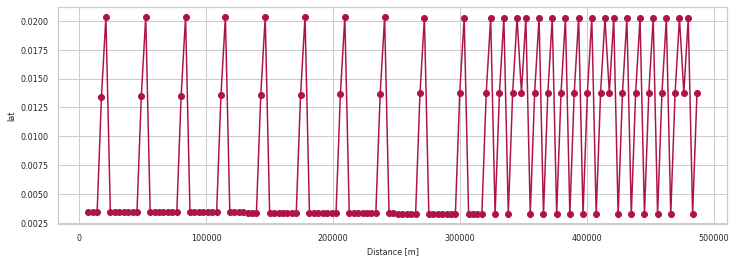

In [112]:
fig, ax = plt.subplots(figsize=(12,4),sharex=True,sharey=True,gridspec_kw={'hspace': 0.05,'wspace': 0.05})
section_osnap.where(section_osnap.c < 490000).lat.diff(dim='c').plot(marker='o')


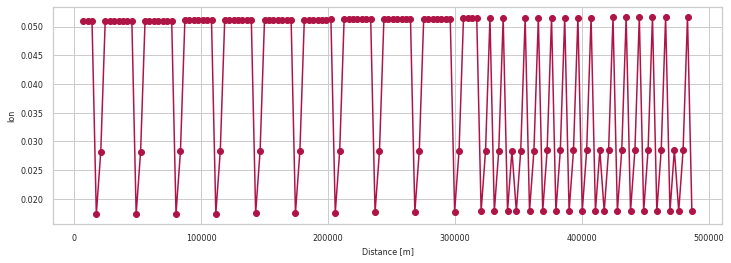

In [113]:
fig, ax = plt.subplots(figsize=(12,4),sharex=True,sharey=True,gridspec_kw={'hspace': 0.05,'wspace': 0.05})
section_osnap.where(section_osnap.c < 490000).lon.diff(dim='c').plot(marker='o')


In [16]:
def plot_westtoeast_properties_new(section):
    
    section_left=section.where((section.c < 490000) & (section.lon.diff(dim='c') > 0.025)).dropna(dim='c', how='all')
    
    section_left['c'] = section_left.c/1000.0
    section_left.c.attrs['units']='km'

    trsp = section_left['u_normal'] * section_left['dx'] * section_left['dz'] / 1e06
    trsp.attrs['long_name']='Transport'
    trsp.attrs['units']='Sv'
    fig, ax = plt.subplots(3,2,figsize=(12,12),sharex=True,sharey=True,gridspec_kw={'hspace': 0.05,'wspace': 0.05})
    
    mean_u_normal = section_left.u_normal.mean(dim="time_counter")
    

    # whole section
#     salinity_levels = [32,33,34,34.2,34.5,34.6,34.7,34.8,34.9,34.92,34.94,34.96,34.98,
#                        35.0]
#     density_levels = [25,26,27,27.3,27.427.5,27.6,27.7,27.75,27.8,27.85,27.88]
    salinity_levels = [34,34.2,34.5,34.6]
    density_levels = [20,27,27.3,27.5,27.6,27.68]

    im2 = ((((section_left.isel(time_counter=slice(0,60)).u_normal.mean(dim="time_counter"))-mean_u_normal
            ))
          .plot.contourf(ax=ax[0,0],cmap=co.cm.balance,add_colorbar=0,levels=np.arange(-0.1,0.11,0.01)))
    CS1 = (section_left.isel(time_counter=slice(0,60)).vosigma0.mean(dim="time_counter")
          .plot.contour(ax=ax[0,0],cmap=co.cm.dense,levels=density_levels,add_colorbar=0))
    section_left['mask'].where(section_left['mask']==0).plot(ax=ax[0,0],cmap=c.ListedColormap(['gray']),add_colorbar=0)

# plot formatting
    ax[0,0].set_ylim(0,750)
    ax[0,0].invert_yaxis()
    ax[0,0].ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
    ax[0,0].clabel(CS1, fontsize=10,fmt='%1.2f',inline_spacing=0,use_clabeltext=True)
#     ax.clabel(CS2, inline=True, fontsize=8,fmt='%1.1f',inline_spacing=-5)
    ax[0,0].set_xlim(0,490)
    ax[0,0].set_xlabel('')
    ax[0,0].text(25,650,'a.  1990-1994')
    
    
    im2 = ((((section_left.isel(time_counter=slice(60,120)).u_normal.mean(dim="time_counter"))-mean_u_normal
            ))
          .plot.contourf(ax=ax[1,0],cmap=co.cm.balance,add_colorbar=0,levels=np.arange(-0.1,0.11,0.01)))
#                          cbar_kwargs={'orientation':'horizontal',
#                                       'aspect':30,
#                                       'pad':0.2,
#                                       'label':'normal velocity difference [m s$^{-1}$]'}))
    CS2 = (section_left.isel(time_counter=slice(60,120)).vosigma0.mean(dim="time_counter")
          .plot.contour(ax=ax[1,0],cmap=co.cm.dense,levels=density_levels,add_colorbar=0))
    section_left['mask'].where(section_left['mask']==0).plot(ax=ax[1,0],cmap=c.ListedColormap(['gray']),add_colorbar=0)

# plot formatting
    ax[1,0].set_ylim(0,750)
    ax[1,0].invert_yaxis()
    ax[1,0].ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
    ax[1,0].clabel(CS2, fontsize=10,fmt='%1.2f',inline_spacing=0,use_clabeltext=True)
#     ax.clabel(CS2, inline=True, fontsize=8,fmt='%1.1f',inline_spacing=-5)
    ax[1,0].set_xlim(0,490)
    ax[1,0].set_xlabel('')
    ax[1,0].text(25,650,'b.  1995-1999')
    
    im2 = ((((section_left.isel(time_counter=slice(120,180)).u_normal.mean(dim="time_counter"))-mean_u_normal
            ))
          .plot.contourf(ax=ax[2,0],cmap=co.cm.balance,add_colorbar=0,levels=np.arange(-0.1,0.11,0.01)))
    CS1 = (section_left.isel(time_counter=slice(120,180)).vosigma0.mean(dim="time_counter")
          .plot.contour(ax=ax[2,0],cmap=co.cm.dense,levels=density_levels,add_colorbar=0))
    section_left['mask'].where(section_left['mask']==0).plot(ax=ax[2,0],cmap=c.ListedColormap(['gray']),add_colorbar=0)

# plot formatting
    ax[2,0].set_ylim(0,750)
    ax[2,0].invert_yaxis()
    ax[2,0].ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
    ax[2,0].clabel(CS1, fontsize=10,fmt='%1.2f',inline_spacing=0,use_clabeltext=True)
#     ax.clabel(CS2, inline=True, fontsize=8,fmt='%1.1f',inline_spacing=-5)
    ax[2,0].set_xlim(0,490)
    ax[2,0].text(25,650,'c.  2000-2004')
    
    
    im2 = ((((section_left.isel(time_counter=slice(180,240)).u_normal.mean(dim="time_counter"))-mean_u_normal
            ))
          .plot.contourf(ax=ax[0,1],cmap=co.cm.balance,add_colorbar=0,levels=np.arange(-0.1,0.11,0.01)))
#                          cbar_kwargs={'orientation':'horizontal',
#                                       'aspect':30,
#                                       'pad':0.2,
#                                       'label':'normal velocity difference [m s$^{-1}$]'}))
    CS2 = (section_left.isel(time_counter=slice(180,240)).vosigma0.mean(dim="time_counter")
          .plot.contour(ax=ax[0,1],cmap=co.cm.dense,levels=density_levels,add_colorbar=0))
    section_left['mask'].where(section_left['mask']==0).plot(ax=ax[0,1],cmap=c.ListedColormap(['gray']),add_colorbar=0)

# plot formatting
    ax[0,1].set_ylim(0,750)
    ax[0,1].invert_yaxis()
    ax[0,1].ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
    ax[0,1].clabel(CS2, fontsize=10,fmt='%1.2f',inline_spacing=0,use_clabeltext=True)
#     ax.clabel(CS2, inline=True, fontsize=8,fmt='%1.1f',inline_spacing=-5)
    ax[0,1].set_xlim(0,490)
    ax[0,1].set_xlabel('')
    ax[0,1].set_ylabel('')
    ax[0,1].text(25,650,'d.  2005-2009')
    
    im2 = ((((section_left.isel(time_counter=slice(240,300)).u_normal.mean(dim="time_counter"))-mean_u_normal
            ))
          .plot.contourf(ax=ax[1,1],cmap=co.cm.balance,add_colorbar=0,levels=np.arange(-0.1,0.11,0.01)))
    CS1 = (section_left.isel(time_counter=slice(240,300)).vosigma0.mean(dim="time_counter")
          .plot.contour(ax=ax[1,1],cmap=co.cm.dense,levels=density_levels,add_colorbar=0))
    section_left['mask'].where(section_left['mask']==0).plot(ax=ax[1,1],cmap=c.ListedColormap(['gray']),add_colorbar=0)

# plot formatting
    ax[1,1].set_ylim(0,750)
    ax[1,1].invert_yaxis()
    ax[1,1].ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
    ax[1,1].clabel(CS1, fontsize=10,fmt='%1.2f',inline_spacing=0,use_clabeltext=True)
#     ax.clabel(CS2, inline=True, fontsize=8,fmt='%1.1f',inline_spacing=-5)
    ax[1,1].set_xlim(0,490)
    ax[1,1].set_xlabel('')
    ax[1,1].set_ylabel('')
    ax[1,1].text(25,650,'e.  2010-2014')
    
    
    im2 = ((((section_left.isel(time_counter=slice(300,360)).u_normal.mean(dim="time_counter"))-mean_u_normal
            ))
          .plot.contourf(ax=ax[2,1],cmap=co.cm.balance,add_colorbar=0,levels=np.arange(-0.1,0.11,0.01)))
#                          cbar_kwargs={'orientation':'horizontal',
#                                       'aspect':30,
#                                       'pad':0.2,
#                                       'label':'normal velocity difference [m s$^{-1}$]'}))
    CS2 = (section_left.isel(time_counter=slice(300,360)).vosigma0.mean(dim="time_counter")
          .plot.contour(ax=ax[2,1],cmap=co.cm.dense,levels=density_levels,add_colorbar=0))
    section_left['mask'].where(section_left['mask']==0).plot(ax=ax[2,1],cmap=c.ListedColormap(['gray']),add_colorbar=0)

# plot formatting
    ax[2,1].set_ylim(0,750)
    ax[2,1].invert_yaxis()
    ax[2,1].ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
    ax[2,1].clabel(CS2, fontsize=10,fmt='%1.2f',inline_spacing=0,use_clabeltext=True)
#     ax.clabel(CS2, inline=True, fontsize=8,fmt='%1.1f',inline_spacing=-5)
    ax[2,1].set_xlim(0,490)
    ax[2,1].set_ylabel('')
    ax[2,1].text(25,650,'f.  2015-2019')
    
  
    fig.colorbar(im2, ax=ax.ravel().tolist(),label='normal velocity anomaly [m s$^{-1}$]',orientation='horizontal',pad=0.1)
    plt.tight_layout()
    
    plt.savefig('u_normal_anomaly.png',dpi=300, bbox_inches='tight')
    return



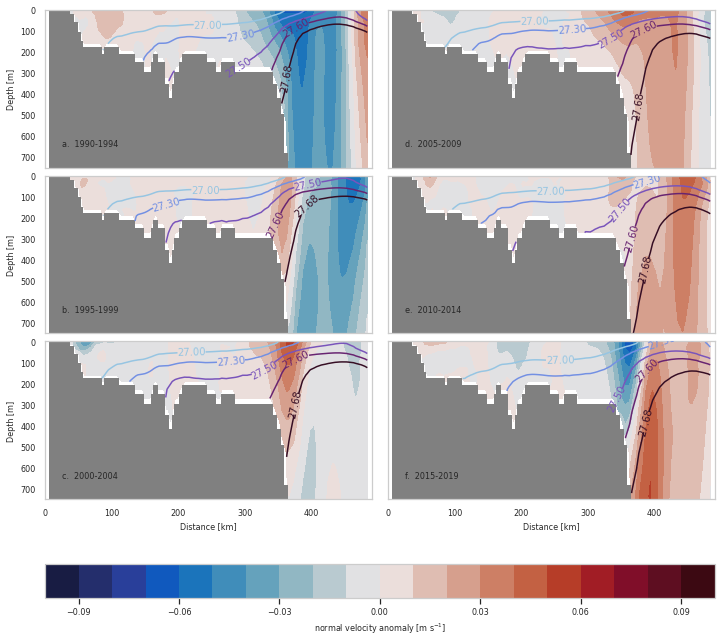

In [17]:
plot_westtoeast_properties_new(section_osnap)

In [116]:
def plot_westtoeast_properties_2(section):
    
    section_left=section.where((section.c < 490000) & (section.lon.diff(dim='c') > 0.025)).dropna(dim='c', how='all')
    
    section_left['c'] = section_left.c/1000.0
    section_left.c.attrs['units']='km'

    trsp = section_left['u_normal'] * section_left['dx'] * section_left['dz'] / 1e06
    trsp.attrs['long_name']='Transport'
    trsp.attrs['units']='Sv'

    mean_u_normal = section_left.u_normal.mean(dim="time_counter")

    salinity_levels = [34,34.2,34.5,34.6]
    density_levels = [20,27,27.3,27.5,27.6,27.65,27.7,27.75]
   
    fig, axs = plt.subplot_mosaic([['(a)', '(a)'], ['(b)', '(c)'], ['(d)', '(e)'], ['(f)', '(g)']],
                              constrained_layout=True,figsize=(12,12))
    for label, ax in axs.items():
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
                fontsize='medium', verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
        
        

#     im2 = ((((section_left.isel(time_counter=slice(0,60)).u_normal.mean(dim="time_counter"))-mean_u_normal
#             ))
#           .plot.contourf(ax=ax[0,0],cmap=co.cm.balance,add_colorbar=0,levels=np.arange(-0.1,0.11,0.01)))
#     CS1 = (section_left.isel(time_counter=slice(0,60)).vosigma0.mean(dim="time_counter")
#           .plot.contour(ax=ax[0,0],cmap=co.cm.dense,levels=density_levels,add_colorbar=0))
#     section_left['mask'].where(section_left['mask']==0).plot(ax=ax[0,0],cmap=c.ListedColormap(['gray']),add_colorbar=0)

# # plot formatting
#     ax[0,0].set_ylim(0,750)
#     ax[0,0].invert_yaxis()
#     ax[0,0].ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
#     ax[0,0].clabel(CS1, fontsize=10,fmt='%1.2f',inline_spacing=0,use_clabeltext=True)
# #     ax.clabel(CS2, inline=True, fontsize=8,fmt='%1.1f',inline_spacing=-5)
#     ax[0,0].set_xlim(0,490)
#     ax[0,0].set_xlabel('')
#     ax[0,0].text(25,650,'a.  1990-1994')
    
    
#     im2 = ((((section_left.isel(time_counter=slice(60,120)).u_normal.mean(dim="time_counter"))-mean_u_normal
#             ))
#           .plot.contourf(ax=ax[1,0],cmap=co.cm.balance,add_colorbar=0,levels=np.arange(-0.1,0.11,0.01)))
# #                          cbar_kwargs={'orientation':'horizontal',
# #                                       'aspect':30,
# #                                       'pad':0.2,
# #                                       'label':'normal velocity difference [m s$^{-1}$]'}))
#     CS2 = (section_left.isel(time_counter=slice(60,120)).vosigma0.mean(dim="time_counter")
#           .plot.contour(ax=ax[1,0],cmap=co.cm.dense,levels=density_levels,add_colorbar=0))
#     section_left['mask'].where(section_left['mask']==0).plot(ax=ax[1,0],cmap=c.ListedColormap(['gray']),add_colorbar=0)

# # plot formatting
#     ax[1,0].set_ylim(0,750)
#     ax[1,0].invert_yaxis()
#     ax[1,0].ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
#     ax[1,0].clabel(CS2, fontsize=10,fmt='%1.2f',inline_spacing=0,use_clabeltext=True)
# #     ax.clabel(CS2, inline=True, fontsize=8,fmt='%1.1f',inline_spacing=-5)
#     ax[1,0].set_xlim(0,490)
#     ax[1,0].set_xlabel('')
#     ax[1,0].text(25,650,'b.  1995-1999')
    
#     im2 = ((((section_left.isel(time_counter=slice(120,180)).u_normal.mean(dim="time_counter"))-mean_u_normal
#             ))
#           .plot.contourf(ax=ax[2,0],cmap=co.cm.balance,add_colorbar=0,levels=np.arange(-0.1,0.11,0.01)))
#     CS1 = (section_left.isel(time_counter=slice(120,180)).vosigma0.mean(dim="time_counter")
#           .plot.contour(ax=ax[2,0],cmap=co.cm.dense,levels=density_levels,add_colorbar=0))
#     section_left['mask'].where(section_left['mask']==0).plot(ax=ax[2,0],cmap=c.ListedColormap(['gray']),add_colorbar=0)

# # plot formatting
#     ax[2,0].set_ylim(0,750)
#     ax[2,0].invert_yaxis()
#     ax[2,0].ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
#     ax[2,0].clabel(CS1, fontsize=10,fmt='%1.2f',inline_spacing=0,use_clabeltext=True)
# #     ax.clabel(CS2, inline=True, fontsize=8,fmt='%1.1f',inline_spacing=-5)
#     ax[2,0].set_xlim(0,490)
#     ax[2,0].text(25,650,'c.  2000-2004')
    
    
#     im2 = ((((section_left.isel(time_counter=slice(180,240)).u_normal.mean(dim="time_counter"))-mean_u_normal
#             ))
#           .plot.contourf(ax=ax[0,1],cmap=co.cm.balance,add_colorbar=0,levels=np.arange(-0.1,0.11,0.01)))
# #                          cbar_kwargs={'orientation':'horizontal',
# #                                       'aspect':30,
# #                                       'pad':0.2,
# #                                       'label':'normal velocity difference [m s$^{-1}$]'}))
#     CS2 = (section_left.isel(time_counter=slice(180,240)).vosigma0.mean(dim="time_counter")
#           .plot.contour(ax=ax[0,1],cmap=co.cm.dense,levels=density_levels,add_colorbar=0))
#     section_left['mask'].where(section_left['mask']==0).plot(ax=ax[0,1],cmap=c.ListedColormap(['gray']),add_colorbar=0)

# # plot formatting
#     ax[0,1].set_ylim(0,750)
#     ax[0,1].invert_yaxis()
#     ax[0,1].ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
#     ax[0,1].clabel(CS2, fontsize=10,fmt='%1.2f',inline_spacing=0,use_clabeltext=True)
# #     ax.clabel(CS2, inline=True, fontsize=8,fmt='%1.1f',inline_spacing=-5)
#     ax[0,1].set_xlim(0,490)
#     ax[0,1].set_xlabel('')
#     ax[0,1].set_ylabel('')
#     ax[0,1].text(25,650,'d.  2005-2009')
    
#     im2 = ((((section_left.isel(time_counter=slice(240,300)).u_normal.mean(dim="time_counter"))-mean_u_normal
#             ))
#           .plot.contourf(ax=ax[1,1],cmap=co.cm.balance,add_colorbar=0,levels=np.arange(-0.1,0.11,0.01)))
#     CS1 = (section_left.isel(time_counter=slice(240,300)).vosigma0.mean(dim="time_counter")
#           .plot.contour(ax=ax[1,1],cmap=co.cm.dense,levels=density_levels,add_colorbar=0))
#     section_left['mask'].where(section_left['mask']==0).plot(ax=ax[1,1],cmap=c.ListedColormap(['gray']),add_colorbar=0)

# # plot formatting
#     ax[1,1].set_ylim(0,750)
#     ax[1,1].invert_yaxis()
#     ax[1,1].ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
#     ax[1,1].clabel(CS1, fontsize=10,fmt='%1.2f',inline_spacing=0,use_clabeltext=True)
# #     ax.clabel(CS2, inline=True, fontsize=8,fmt='%1.1f',inline_spacing=-5)
#     ax[1,1].set_xlim(0,490)
#     ax[1,1].set_xlabel('')
#     ax[1,1].set_ylabel('')
#     ax[1,1].text(25,650,'e.  2010-2014')
    
    
#     im2 = ((((section_left.isel(time_counter=slice(300,360)).u_normal.mean(dim="time_counter"))-mean_u_normal
#             ))
#           .plot.contourf(ax=ax[2,1],cmap=co.cm.balance,add_colorbar=0,levels=np.arange(-0.1,0.11,0.01)))
# #                          cbar_kwargs={'orientation':'horizontal',
# #                                       'aspect':30,
# #                                       'pad':0.2,
# #                                       'label':'normal velocity difference [m s$^{-1}$]'}))
#     CS2 = (section_left.isel(time_counter=slice(300,360)).vosigma0.mean(dim="time_counter")
#           .plot.contour(ax=ax[2,1],cmap=co.cm.dense,levels=density_levels,add_colorbar=0))
#     section_left['mask'].where(section_left['mask']==0).plot(ax=ax[2,1],cmap=c.ListedColormap(['gray']),add_colorbar=0)

# # plot formatting
#     ax[2,1].set_ylim(0,750)
#     ax[2,1].invert_yaxis()
#     ax[2,1].ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
#     ax[2,1].clabel(CS2, fontsize=10,fmt='%1.2f',inline_spacing=0,use_clabeltext=True)
# #     ax.clabel(CS2, inline=True, fontsize=8,fmt='%1.1f',inline_spacing=-5)
#     ax[2,1].set_xlim(0,490)
#     ax[2,1].set_ylabel('')
#     ax[2,1].text(25,650,'f.  2015-2019')
    
  
#     fig.colorbar(im2, ax=ax.ravel().tolist(),label='normal velocity anomaly [m s$^{-1}$]',orientation='horizontal',pad=0.1)
#     plt.tight_layout()
    
#     plt.savefig('u_normal_anomaly.png',dpi=300, bbox_inches='tight')
    return



In [118]:
plot_westtoeast_properties_2(section_osnap)

AttributeError: module 'matplotlib.pyplot' has no attribute 'subplot_mosaic'

In [78]:
def plot_westtoeast_properties_new_annual(section):
    
    section_left=section.where(section.c < 1700000)
    section_left['c'] = section_left.c/1000.0
    section_left.c.attrs['units']='km'

    trsp = section_left['u_normal'] * section_left['dx'] * section_left['dz'] / 1e06
    trsp.attrs['long_name']='Transport'
    trsp.attrs['units']='Sv'
    fig, ax = plt.subplots(3,3,figsize=(18,12),sharex=True,sharey=True,gridspec_kw={'hspace': 0.05,'wspace': 0.05})
    
    mean_u_normal = section_left.u_normal.mean(dim="time_counter")
    

    # whole section
#     salinity_levels = [32,33,34,34.2,34.5,34.6,34.7,34.8,34.9,34.92,34.94,34.96,34.98,
#                        35.0]
#     density_levels = [25,26,27,27.3,27.427.5,27.6,27.7,27.75,27.8,27.85,27.88]
    salinity_levels = [34,34.2,34.5,34.6]
    density_levels = [20,27,27.3,27.5,27.6,27.68]

    im2 = ((((section_left.isel(time_counter=slice(251,255)).u_normal.mean(dim="time_counter"))-mean_u_normal
            ))
          .plot.contourf(ax=ax[0,0],cmap=co.cm.balance,add_colorbar=0,levels=np.arange(-0.1,0.11,0.01)))
    CS1 = (section_left.isel(time_counter=slice(251,255)).vosigma0.mean(dim="time_counter")
          .plot.contour(ax=ax[0,0],cmap=co.cm.dense,levels=density_levels,add_colorbar=0))
    section_left['mask'].where(section_left['mask']==0).plot(ax=ax[0,0],cmap=c.ListedColormap(['gray']),add_colorbar=0)

# plot formatting
    ax[0,0].set_ylim(0,750)
    ax[0,0].invert_yaxis()
    ax[0,0].ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
    ax[0,0].clabel(CS1, fontsize=10,fmt='%1.2f',inline_spacing=0,use_clabeltext=True)
#     ax.clabel(CS2, inline=True, fontsize=8,fmt='%1.1f',inline_spacing=-5)
    ax[0,0].set_xlim(0,1700)
    ax[0,0].set_xlabel('')
    ax[0,0].text(25,650,'a.  DJFM 2010-2011')
    
    
    im2 = ((((section_left.isel(time_counter=slice(263,267)).u_normal.mean(dim="time_counter"))-mean_u_normal
            ))
          .plot.contourf(ax=ax[1,0],cmap=co.cm.balance,add_colorbar=0,levels=np.arange(-0.1,0.11,0.01)))
#                          cbar_kwargs={'orientation':'horizontal',
#                                       'aspect':30,
#                                       'pad':0.2,
#                                       'label':'normal velocity difference [m s$^{-1}$]'}))
    CS2 = (section_left.isel(time_counter=slice(263,267)).vosigma0.mean(dim="time_counter")
          .plot.contour(ax=ax[1,0],cmap=co.cm.dense,levels=density_levels,add_colorbar=0))
    section_left['mask'].where(section_left['mask']==0).plot(ax=ax[1,0],cmap=c.ListedColormap(['gray']),add_colorbar=0)

# plot formatting
    ax[1,0].set_ylim(0,750)
    ax[1,0].invert_yaxis()
    ax[1,0].ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
    ax[1,0].clabel(CS2, fontsize=10,fmt='%1.2f',inline_spacing=0,use_clabeltext=True)
#     ax.clabel(CS2, inline=True, fontsize=8,fmt='%1.1f',inline_spacing=-5)
    ax[1,0].set_xlim(0,1700)
    ax[1,0].set_xlabel('')
    ax[1,0].text(25,650,'b.  DJFM 2011-2012')
    
    im2 = ((((section_left.isel(time_counter=slice(275,279)).u_normal.mean(dim="time_counter"))-mean_u_normal
            ))
          .plot.contourf(ax=ax[2,0],cmap=co.cm.balance,add_colorbar=0,levels=np.arange(-0.1,0.11,0.01)))
    CS1 = (section_left.isel(time_counter=slice(275,279)).vosigma0.mean(dim="time_counter")
          .plot.contour(ax=ax[2,0],cmap=co.cm.dense,levels=density_levels,add_colorbar=0))
    section_left['mask'].where(section_left['mask']==0).plot(ax=ax[2,0],cmap=c.ListedColormap(['gray']),add_colorbar=0)

# plot formatting
    ax[2,0].set_ylim(0,750)
    ax[2,0].invert_yaxis()
    ax[2,0].ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
    ax[2,0].clabel(CS1, fontsize=10,fmt='%1.2f',inline_spacing=0,use_clabeltext=True)
#     ax.clabel(CS2, inline=True, fontsize=8,fmt='%1.1f',inline_spacing=-5)
    ax[2,0].set_xlim(0,1700)
    ax[2,0].text(25,650,'c.  DJFM 2012-2013')
    
    
    im2 = ((((section_left.isel(time_counter=slice(287,291)).u_normal.mean(dim="time_counter"))-mean_u_normal
            ))
          .plot.contourf(ax=ax[0,1],cmap=co.cm.balance,add_colorbar=0,levels=np.arange(-0.1,0.11,0.01)))
#                          cbar_kwargs={'orientation':'horizontal',
#                                       'aspect':30,
#                                       'pad':0.2,
#                                       'label':'normal velocity difference [m s$^{-1}$]'}))
    CS2 = (section_left.isel(time_counter=slice(287,291)).vosigma0.mean(dim="time_counter")
          .plot.contour(ax=ax[0,1],cmap=co.cm.dense,levels=density_levels,add_colorbar=0))
    section_left['mask'].where(section_left['mask']==0).plot(ax=ax[0,1],cmap=c.ListedColormap(['gray']),add_colorbar=0)

# plot formatting
    ax[0,1].set_ylim(0,750)
    ax[0,1].invert_yaxis()
    ax[0,1].ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
    ax[0,1].clabel(CS2, fontsize=10,fmt='%1.2f',inline_spacing=0,use_clabeltext=True)
#     ax.clabel(CS2, inline=True, fontsize=8,fmt='%1.1f',inline_spacing=-5)
    ax[0,1].set_xlim(0,1700)
    ax[0,1].set_xlabel('')
    ax[0,1].set_ylabel('')
    ax[0,1].text(25,650,'d.  DJFM 2013-2014')
    
    im2 = ((((section_left.isel(time_counter=slice(299,303)).u_normal.mean(dim="time_counter"))-mean_u_normal
            ))
          .plot.contourf(ax=ax[1,1],cmap=co.cm.balance,add_colorbar=0,levels=np.arange(-0.1,0.11,0.01)))
    CS1 = (section_left.isel(time_counter=slice(299,303)).vosigma0.mean(dim="time_counter")
          .plot.contour(ax=ax[1,1],cmap=co.cm.dense,levels=density_levels,add_colorbar=0))
    section_left['mask'].where(section_left['mask']==0).plot(ax=ax[1,1],cmap=c.ListedColormap(['gray']),add_colorbar=0)

# plot formatting
    ax[1,1].set_ylim(0,750)
    ax[1,1].invert_yaxis()
    ax[1,1].ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
    ax[1,1].clabel(CS1, fontsize=10,fmt='%1.2f',inline_spacing=0,use_clabeltext=True)
#     ax.clabel(CS2, inline=True, fontsize=8,fmt='%1.1f',inline_spacing=-5)
    ax[1,1].set_xlim(0,1700)
    ax[1,1].set_xlabel('')
    ax[1,1].set_ylabel('')
    ax[1,1].text(25,650,'e.  DJFM 2014-2015')
    
    
    im2 = ((((section_left.isel(time_counter=slice(311,315)).u_normal.mean(dim="time_counter"))-mean_u_normal
            ))
          .plot.contourf(ax=ax[2,1],cmap=co.cm.balance,add_colorbar=0,levels=np.arange(-0.1,0.11,0.01)))
#                          cbar_kwargs={'orientation':'horizontal',
#                                       'aspect':30,
#                                       'pad':0.2,
#                                       'label':'normal velocity difference [m s$^{-1}$]'}))
    CS2 = (section_left.isel(time_counter=slice(311,315)).vosigma0.mean(dim="time_counter")
          .plot.contour(ax=ax[2,1],cmap=co.cm.dense,levels=density_levels,add_colorbar=0))
    section_left['mask'].where(section_left['mask']==0).plot(ax=ax[2,1],cmap=c.ListedColormap(['gray']),add_colorbar=0)

# plot formatting
    ax[2,1].set_ylim(0,750)
    ax[2,1].invert_yaxis()
    ax[2,1].ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
    ax[2,1].clabel(CS2, fontsize=10,fmt='%1.2f',inline_spacing=0,use_clabeltext=True)
#     ax.clabel(CS2, inline=True, fontsize=8,fmt='%1.1f',inline_spacing=-5)
    ax[2,1].set_xlim(0,1700)
    ax[2,1].set_ylabel('')
    ax[2,1].text(25,650,'f.  DJFM 2015-2016')
    
    im2 = ((((section_left.isel(time_counter=slice(323,327)).u_normal.mean(dim="time_counter"))-mean_u_normal
            ))
          .plot.contourf(ax=ax[0,2],cmap=co.cm.balance,add_colorbar=0,levels=np.arange(-0.1,0.11,0.01)))
#                          cbar_kwargs={'orientation':'horizontal',
#                                       'aspect':30,
#                                       'pad':0.2,
#                                       'label':'normal velocity difference [m s$^{-1}$]'}))
    CS2 = (section_left.isel(time_counter=slice(323,327)).vosigma0.mean(dim="time_counter")
          .plot.contour(ax=ax[0,2],cmap=co.cm.dense,levels=density_levels,add_colorbar=0))
    section_left['mask'].where(section_left['mask']==0).plot(ax=ax[0,2],cmap=c.ListedColormap(['gray']),add_colorbar=0)

# plot formatting
    ax[0,2].set_ylim(0,750)
    ax[0,2].invert_yaxis()
    ax[0,2].ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
    ax[0,2].clabel(CS2, fontsize=10,fmt='%1.2f',inline_spacing=0,use_clabeltext=True)
#     ax.clabel(CS2, inline=True, fontsize=8,fmt='%1.1f',inline_spacing=-5)
    ax[0,2].set_xlim(0,1700)
    ax[0,2].set_xlabel('')
    ax[0,2].set_ylabel('')
    ax[0,2].text(25,650,'d.  DJFM 2016-2017')
    
    im2 = ((((section_left.isel(time_counter=slice(335,339)).u_normal.mean(dim="time_counter"))-mean_u_normal
            ))
          .plot.contourf(ax=ax[1,2],cmap=co.cm.balance,add_colorbar=0,levels=np.arange(-0.1,0.11,0.01)))
    CS1 = (section_left.isel(time_counter=slice(335,339)).vosigma0.mean(dim="time_counter")
          .plot.contour(ax=ax[1,2],cmap=co.cm.dense,levels=density_levels,add_colorbar=0))
    section_left['mask'].where(section_left['mask']==0).plot(ax=ax[1,2],cmap=c.ListedColormap(['gray']),add_colorbar=0)

# plot formatting
    ax[1,2].set_ylim(0,750)
    ax[1,2].invert_yaxis()
    ax[1,2].ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
    ax[1,2].clabel(CS1, fontsize=10,fmt='%1.2f',inline_spacing=0,use_clabeltext=True)
#     ax.clabel(CS2, inline=True, fontsize=8,fmt='%1.1f',inline_spacing=-5)
    ax[1,2].set_xlim(0,1700)
    ax[1,2].set_xlabel('')
    ax[1,2].set_ylabel('')
    ax[1,2].text(25,650,'e.  DJFM 2017-2018')
    
    
    im2 = ((((section_left.isel(time_counter=slice(347,351)).u_normal.mean(dim="time_counter"))-mean_u_normal
            ))
          .plot.contourf(ax=ax[2,2],cmap=co.cm.balance,add_colorbar=0,levels=np.arange(-0.1,0.11,0.01)))
#                          cbar_kwargs={'orientation':'horizontal',
#                                       'aspect':30,
#                                       'pad':0.2,
#                                       'label':'normal velocity difference [m s$^{-1}$]'}))
    CS2 = (section_left.isel(time_counter=slice(347,351)).vosigma0.mean(dim="time_counter")
          .plot.contour(ax=ax[2,2],cmap=co.cm.dense,levels=density_levels,add_colorbar=0))
    section_left['mask'].where(section_left['mask']==0).plot(ax=ax[2,2],cmap=c.ListedColormap(['gray']),add_colorbar=0)

# plot formatting
    ax[2,2].set_ylim(0,750)
    ax[2,2].invert_yaxis()
    ax[2,2].ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
    ax[2,2].clabel(CS2, fontsize=10,fmt='%1.2f',inline_spacing=0,use_clabeltext=True)
#     ax.clabel(CS2, inline=True, fontsize=8,fmt='%1.1f',inline_spacing=-5)
    ax[2,2].set_xlim(0,1700)
    ax[2,2].set_ylabel('')
    ax[2,2].text(25,650,'f.  DJFM 2018-2019')
    
  
    fig.colorbar(im2, ax=ax.ravel().tolist(),label='normal velocity anomaly [m s$^{-1}$]',orientation='horizontal',pad=0.1)
    plt.tight_layout()
    
    plt.savefig('u_normal_anomaly_annual.png',dpi=300, bbox_inches='tight')
    return



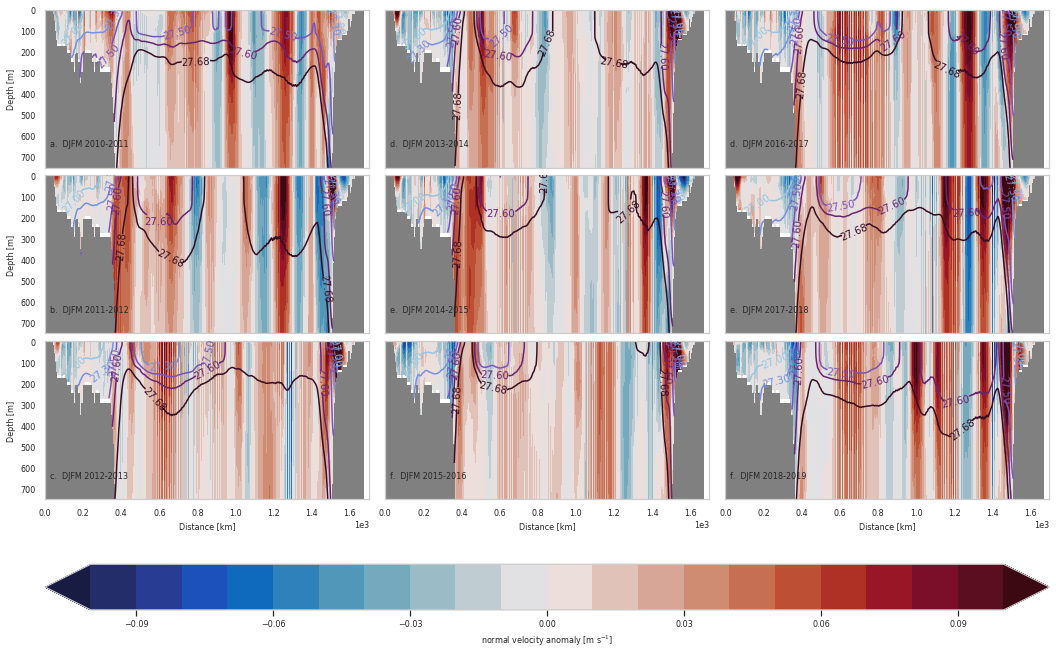

In [79]:
plot_westtoeast_properties_new_annual(section_osnap)

In [ ]:
section_osnap

In [ ]:
def plot_time_series(fxs,colors,labels,title):
    sns.set(style="whitegrid")
    sns.set_palette("colorblind")

    fig,ax = plt.subplots(1,1,figsize=(8,4),sharex=True)
    plt.tight_layout()

    for ii,curve in enumerate(zip(fxs,colors,labels)):
        curve[0].plot(color=curve[1],label=curve[2],zorder=10-ii,linewidth = 1)

    # ax.set_ylim(bottom=0) 
    ax.set_xlabel('')
    ax.set_ylabel('volume flux [Sv]')
    ax.set_title(title)
    ax.legend()
    
    plt.savefig(project_path / path_figures / 'timeseries.png')
    
    return
    

In [ ]:
plot_time_series([dVbydt_sig_son.isel(vosigma0_bin=isigsel),
                 -heat_flux__son.isel(vosigma0_bin=isigsel),
                 -freshwater_son.isel(vosigma0_bin=isigsel),
                  tot_inflow_son.isel(vosigma0_bin=isigsel),
                  osnap_outf_son.isel(vosigma0_bin=isigsel),
                 -net_mixing_son.isel(vosigma0_bin=isigsel)],
                 ['k','C0','C1','C2','C3','C4'],
                 ['volume tendency','heat flux','freshwater flux','tot inflow','outflow','mixing'],
                 'watermass balance son 27.65')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,4),sharex=True)
plt.tight_layout()

fx_27_40 = volume_by_sigma.cumsum(dim='pot_dens_bin').isel(pot_dens_bin=1740)
fx_27_40_filtered = xr.apply_ufunc(butter_lowpass_filtfilt, fx_27_40,cutoff,fs,
                         dask='parallelized')

fx_27_40.plot(color='C0',alpha=0.7,linewidth=1)
fx_27_40_filtered.plot(color='C0',zorder=10,linewidth=2,label=r'volume $\sigma_0 < 27.40$')

fx_27_65 = volume_by_sigma.cumsum(dim='pot_dens_bin').isel(pot_dens_bin=1765)
fx_27_65_filtered = xr.apply_ufunc(butter_lowpass_filtfilt, fx_27_65,cutoff,fs,
                         dask='parallelized')

fx_27_65.plot(color='C1',alpha=0.7,linewidth=1)
fx_27_65_filtered.plot(color='C1',zorder=10,linewidth=2,label=r'volume $\sigma_0 < 27.65$')

fx_27_75 = volume_by_sigma.cumsum(dim='pot_dens_bin').isel(pot_dens_bin=1775)
fx_27_75_filtered = xr.apply_ufunc(butter_lowpass_filtfilt, fx_27_75,cutoff,fs,
                         dask='parallelized')

fx_27_75.plot(color='C2',alpha=0.7,linewidth=1)
fx_27_75_filtered.plot(color='C2',zorder=10,linewidth=2,label=r'volume $\sigma_0 < 27.75$')

ax.set_title('')
ax.set_ylim(bottom=0)
ax.set_xlabel('')
ax.set_ylabel(r'volume [m$^3$]')
ax.legend()
plt.savefig(project_path / path_figures / 'watermass_volume_change.png',dpi=300, bbox_inches='tight')


In [ ]:
amoc_osnap_sumup

In [ ]:
amoc_totin_sumup = amoc_osnap_lsn_sumup - amoc_davis_sumup - amoc_hudso_sumup
amoc_netin_sumup = amoc_osnap_sumup - amoc_davis_sumup - amoc_hudso_sumup

fig,ax = plt.subplots(3,1,figsize=(8,8),sharex=True)
plt.tight_layout()

(amoc_totin_sumup).isel(vosigma0_bin=1750).plot(ax=ax[0])
((amoc_totin_sumup).isel(vosigma0_bin=-1)-
(amoc_totin_sumup).isel(vosigma0_bin=1750)).plot(ax=ax[0])
(amoc_totin_sumup).isel(vosigma0_bin=-1).plot(ax=ax[0])

(amoc_osnap_lss_sumup).isel(vosigma0_bin=1750).plot(ax=ax[1])
((amoc_osnap_lss_sumup).isel(vosigma0_bin=-1)-
(amoc_osnap_lss_sumup).isel(vosigma0_bin=1750)).plot(ax=ax[1])
(amoc_osnap_lss_sumup).isel(vosigma0_bin=-1).plot(ax=ax[1])

(amoc_netin_sumup).isel(vosigma0_bin=1750).plot(ax=ax[2])
((amoc_netin_sumup).isel(vosigma0_bin=-1)-
(amoc_netin_sumup).isel(vosigma0_bin=1750)).plot(ax=ax[2])
(amoc_netin_sumup).isel(vosigma0_bin=-1).plot(ax=ax[2])



# (-1*amoc_totin_sumup).cumsum(dim='vosigma0_bin').isel(vosigma0_bin=1750).plot(ax=ax[1])
# (-1*amoc_totin_sumup).cumsum(dim='vosigma0_bin').isel(vosigma0_bin=1755).plot(ax=ax[1])
# (-1*amoc_totin_sumup).cumsum(dim='vosigma0_bin').isel(vosigma0_bin=1760).plot(ax=ax[1])
# (-1*amoc_totin_sumup).cumsum(dim='vosigma0_bin').isel(vosigma0_bin=1765).plot(ax=ax[1])
# (-1*amoc_totin_sumup).cumsum(dim='vosigma0_bin').isel(vosigma0_bin=1770).plot(ax=ax[1])
# (-1*amoc_totin_sumup).cumsum(dim='vosigma0_bin').isel(vosigma0_bin=1775).plot(ax=ax[1])
# (-1*amoc_totin_sumup).cumsum(dim='vosigma0_bin').isel(vosigma0_bin=1780).plot(ax=ax[1])
# (-1*amoc_totin_sumup).cumsum(dim='vosigma0_bin').isel(vosigma0_bin=1785).plot(ax=ax[1])
# (-1*amoc_totin_sumup).cumsum(dim='vosigma0_bin').isel(vosigma0_bin=1790).plot(ax=ax[1])
# ((-1*amoc_totin_sumup).cumsum(dim='vosigma0_bin').isel(vosigma0_bin=-1)-
# (-1*amoc_totin_sumup).cumsum(dim='vosigma0_bin').isel(vosigma0_bin=1765)).plot(ax=ax[1])
# (-1*amoc_totin_sumup).cumsum(dim='vosigma0_bin').isel(vosigma0_bin=-1).plot(ax=ax[1])



# ax[0].set_title('')
ax[0].set_ylim(bottom=0)
ax[1].set_ylim(top=0)
# ax.set_xlabel('')
# ax.set_ylabel(r'volume [m$^3$]')
# ax.legend()
# plt.savefig(project_path / path_figures / 'watermass_volume_change.png',dpi=300, bbox_inches='tight')


In [ ]:
vcdata_path = project_path / path_data_section / "watermassBudget" / "surfaceFluxes" 

In [ ]:
surface_area_sigma = xr.open_dataarray(vcdata_path / 'surface_area_sigma.nc')

In [ ]:
surface_area_sigma_filtered = xr.apply_ufunc(butter_lowpass_filtfilt, surface_area_sigma.isel(sosigma0_bin=1765),cutoff,fs,
                         dask='parallelized')

In [ ]:
surface_area_sigma.isel(sosigma0_bin=1765).plot()
surface_area_sigma_filtered.plot()